In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [290]:
experiment_data = pd.read_excel("./1. No Action Parameter Variation/results.xlsx", sheet_name=None)
experiment_data.keys()

dict_keys(['Model Version', 'Inputs', 'Boxplot Statistics', '(Output x Input) Variation', 'Global Temperature Dataset', 'Global Emission PPM Dataset', 'Global Forest Area Dataset', 'Global Emission Dataset'])

In [ ]:
experiment_data_variation = experiment_data["(Output x Input) Variation"]
experiment_data_variation

Climate Sensitivity  Forest CO2 Capture  Temperature 2024  \
0                    2.5                 2.8          1.160039   
1                    2.5                 2.9          1.155676   
2                    2.5                 3.0          1.151307   
3                    2.5                 3.1          1.146935   
4                    2.5                 3.2          1.142557   
..                   ...                 ...               ...   
347                  4.0                 4.5          1.196340   
348                  4.0                 4.6          1.189228   
349                  4.0                 4.7          1.182108   
350                  4.0                 4.8          1.174980   
351                  4.0                 4.9          1.167844   

     Temperature 2050  Temperature 2100  \
0            1.777733          2.717528   
1            1.764858          2.695071   
2            1.751940          2.672476   
3            1.738976          2.649741   
4            1.725968          2.626865   
..                ...               ...   
347          1.944161          3.165192   
348          1.922281          3.125095   
349          1.900319          3.084723   
350          1.878277          3.044071   
351          1.856153          3.003136   

     Year Temperature Exceeds 1.5 Threshold  \
0                                      2038   
1                                      2039   
2                                      2039   
3                                      2039   
4                                      2040   
..                                      ...   
347                                    2035   
348                                    2035   
349                                    2036   
350                                    2036   
351                                    2037   

     Year Temperature Exceeds 2.0 Threshold  CO2 Concentration 2024  
0                                      2061              429.147999  
1                                      2062              428.632830  
2                                      2063              428.117662  
3                                      2063              427.602494  
4                                      2064              427.087326  
..                                      ...                     ...  
347                                    2053              420.390138  
348                                    2053              419.874970  
349                                    2054              419.359801  
350                                    2055              418.844633  
351                                    2056              418.329465  

[352 rows x 8 columns]

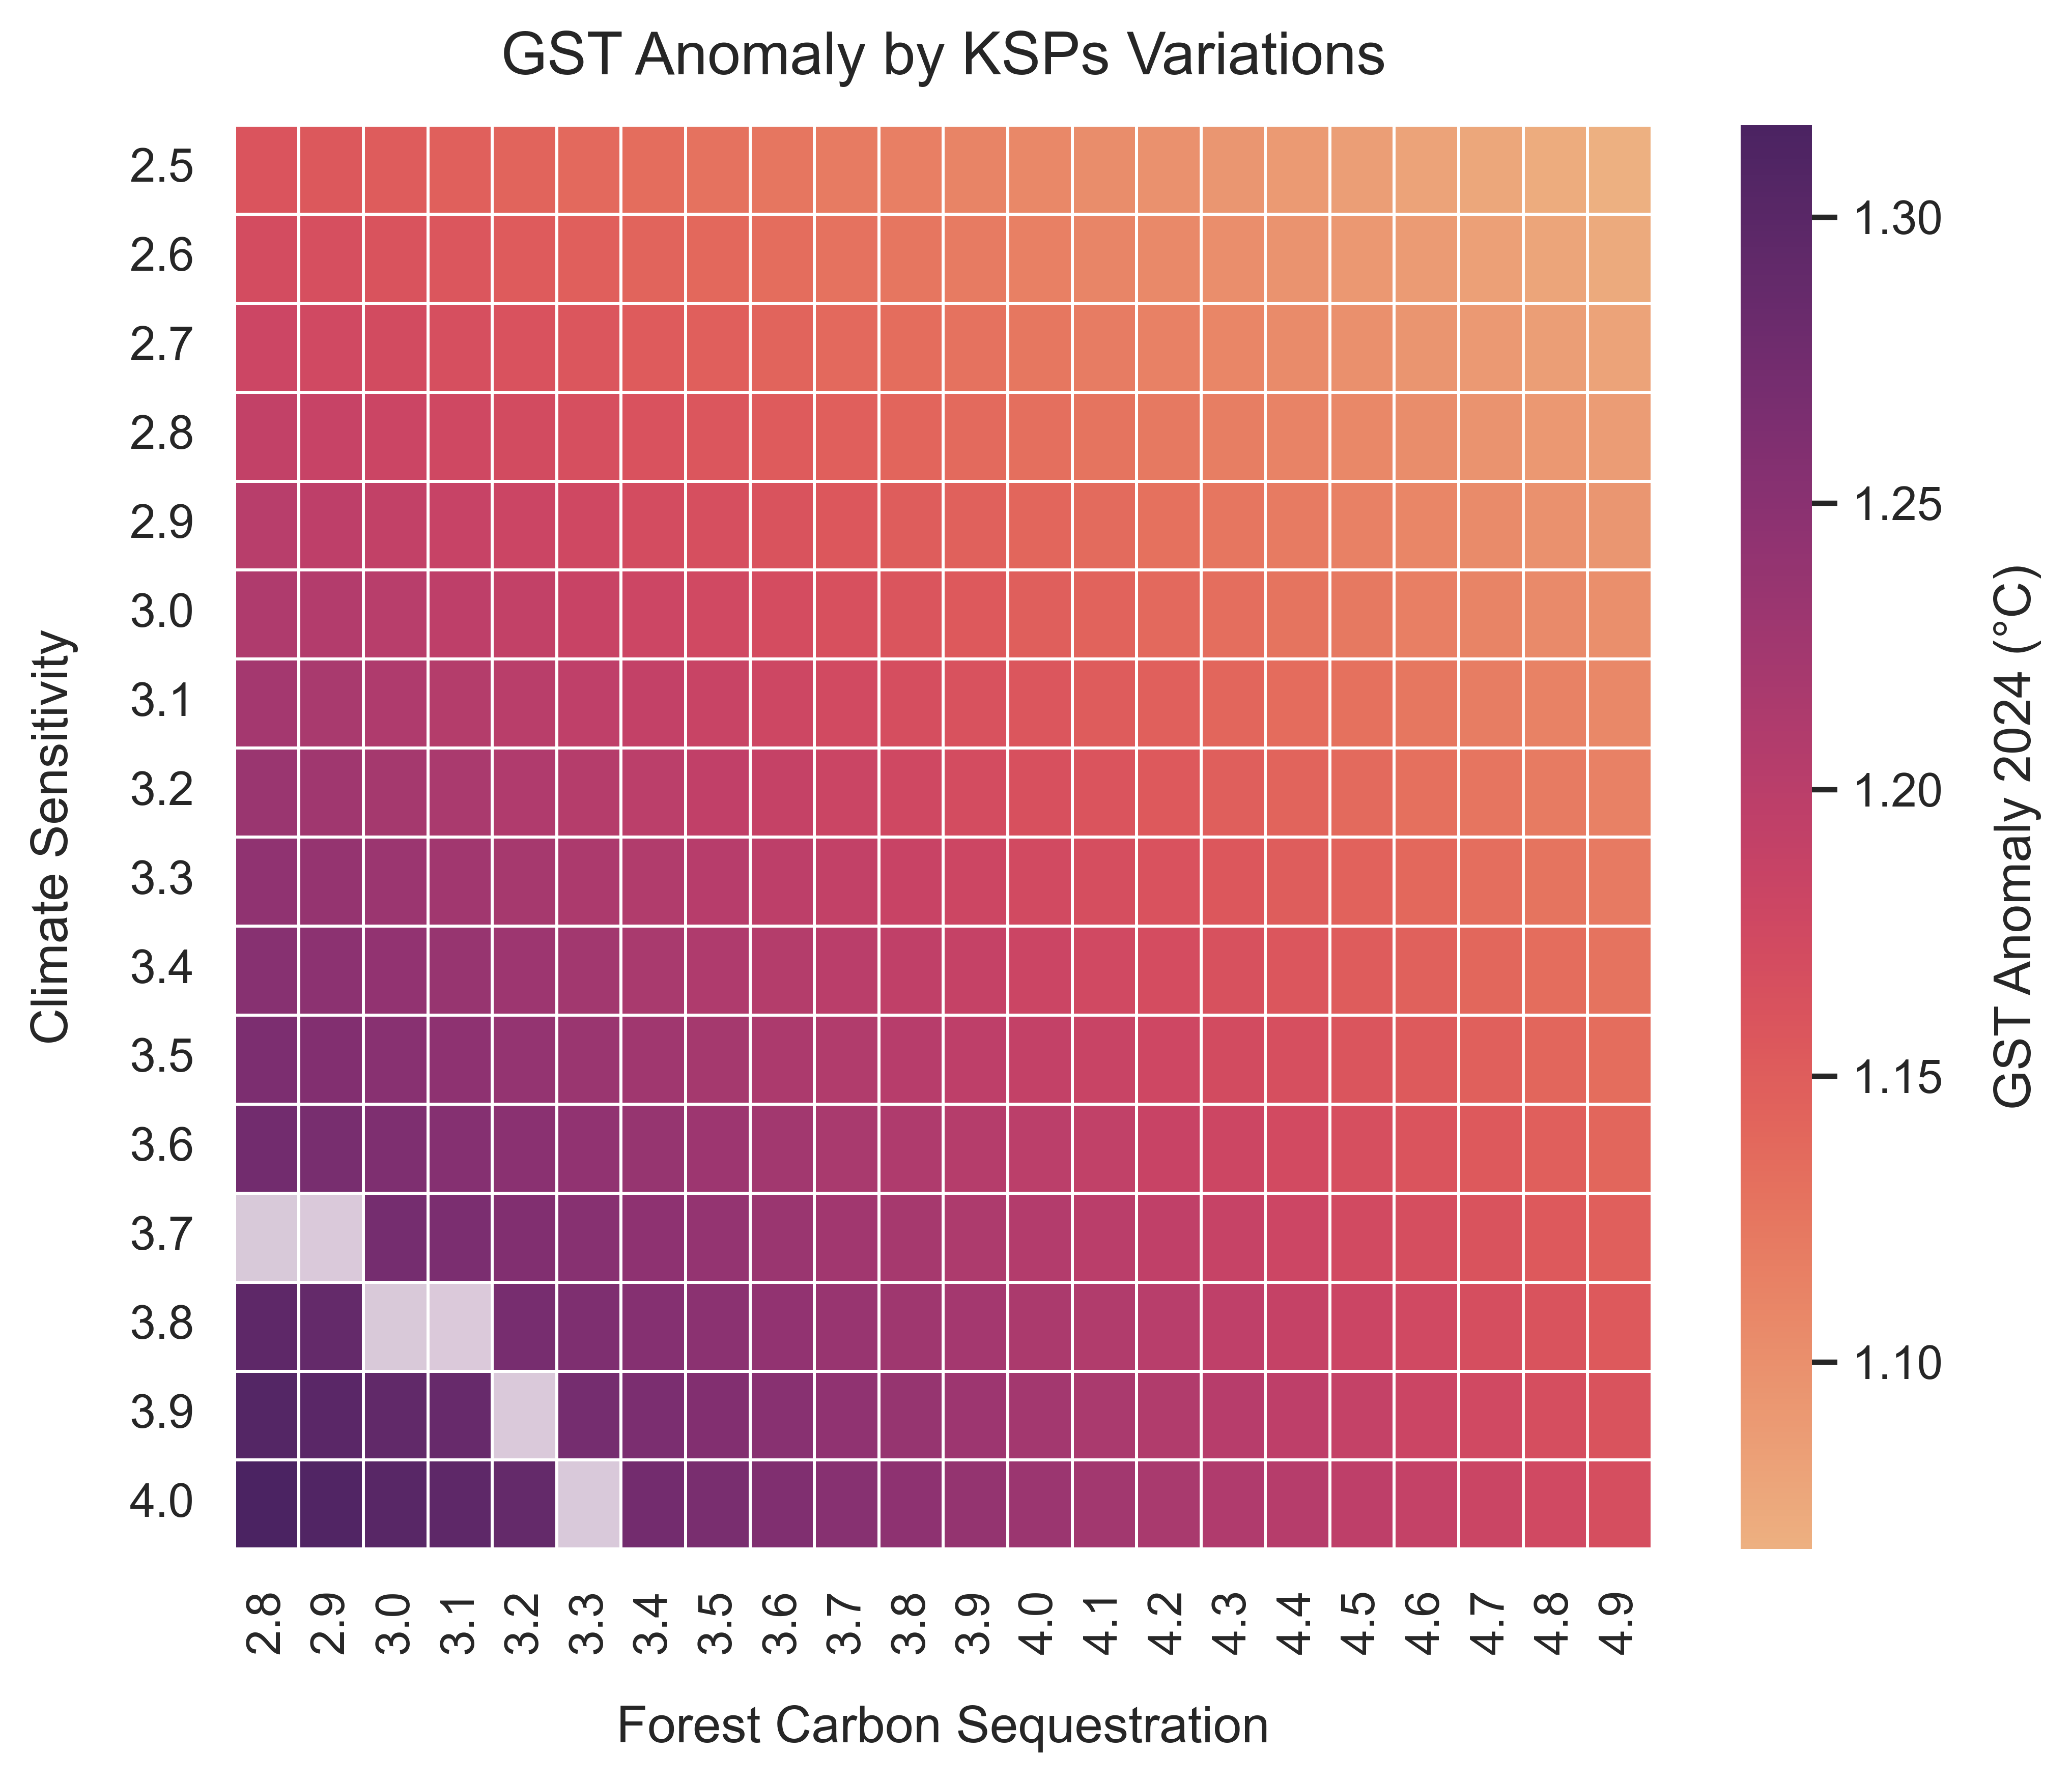

In [281]:
in1 = "Climate Sensitivity"
in2 = "Forest CO2 Capture"
out = "Temperature 2024"
# 1. Heatmap
# Setting the seaborn theme to "darkgrid" for better readability
sns.set_theme(style="darkgrid")
# sns.set_context("notebook")

plt.figure(figsize=(7, 6), dpi=600)

pivot_data = experiment_data_variation.pivot(index=in1, columns=in2, values=out)
ax = sns.heatmap(
    pivot_data,
    cmap="flare",
    cbar=True,
    linewidths=0.5,  # Add grid for better separation
)

# Second: Overlay heatmap for rounded values == 1.28
highlight_mask = np.round(pivot_data.values, 2) == 1.28  # Mask for highlighted values

# Overlay heatmap (Yellow for matching values, transparent otherwise)
sns.heatmap(
    pivot_data,
    mask=~highlight_mask,  # Only show values that match
    cmap=sns.color_palette(["white"], as_cmap=True),  # Overlay with yellow
    linewidths=0.5,
    alpha=0.75,  # Make overlay slightly transparent
    cbar=False  # No separate color bar for overlay
)


plt.title("GST Anomaly by KSPs Variations", fontsize=14, pad=12)
cbar = ax.collections[0].colorbar
cbar.set_label("GST Anomaly 2024 (°C)", labelpad=12)
plt.xlabel("Forest Carbon Sequestration", labelpad=12)  # Labeling X-axis with in2 (Forest CO2 Capture)
plt.ylabel(in1, labelpad=12)  # Labeling Y-axis with in1 (Climate Sensitivity)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [282]:
def create_dataset(dataset):
    dataset_clean = dataset.drop(columns=["Unnamed: 0"], axis=1)
    dataset_clean = dataset_clean.dropna(axis=0)

    df_values = []
    curr_x_values = []
    curr_y_values = []
    first = True
    for _, r in dataset_clean.iterrows():
        if r[0] == "Global Temperature Dataset":
            continue
        if r[0] == "X" and r[1] == "Y":
            if len(curr_x_values) > 0:
                if first:
                    df_values.append(curr_x_values)
                    first = False
                df_values.append(curr_y_values)
                curr_x_values = []
                curr_y_values = []
        else:
            curr_x_values.append(r[0])
            curr_y_values.append(r[1])

    # Convert to DataFrame and transpose (to make columns into rows)
    df = pd.DataFrame(df_values).T

    df.columns = ["X"] + [f"Y{i+1}" for i in range(len(df_values) - 1)]
    df["X"] = df["X"] + 2015
    df["X"] = df["X"].astype('int')
    # Ensure the 'date' column is in datetime format
    df = df[df["X"] != 2101]
    # Set 'date' as the index
    df.set_index("X", inplace=True)

    return df


def create_time_series_plot(ds, configs):

    # Compute summary statistics correctly
    # Setting the seaborn theme to "darkgrid" for better readability
    sns.set_theme(style="darkgrid")

    quantiles = ds.quantile([0, 0.25, 0.5, 0.75, 1], axis=1).T
    quantiles.columns = ["min", "q1", "median", "q3", "max"]
    quantiles["date"] = ds.index  # Assign correct date index

    # Convert index to datetime format
    quantiles["date"] = pd.to_datetime(quantiles["date"])

    # Ensure all data is numeric
    quantiles = quantiles.apply(pd.to_numeric)

    # Convert data to NumPy arrays to avoid potential issues
    dates = quantiles["date"].values
    min_values = quantiles["min"].values
    max_values = quantiles["max"].values
    q1_values = quantiles["q1"].values
    q3_values = quantiles["q3"].values
    median_values = quantiles["median"].values

    # Plot
    plt.figure(figsize=(8, 6), dpi=600)

    # Create a seaborn line plot for the median
    sns.lineplot(x=dates, y=median_values, color=configs["color"], linewidth=2, label="Median")

    # Add shaded areas using seaborn's fill_between functionality
    plt.fill_between(dates, min_values, max_values, alpha=0.2, color=configs["color"], label="Min-Max")
    plt.fill_between(dates, q1_values, q3_values, alpha=0.3, color=configs["color"], label="Q1-Q3")


    # Formatting
    plt.legend(loc=configs["legend_loc"])
    plt.xlabel("Year", labelpad=12)
    plt.ylabel(configs["yLabel"], labelpad=12)
    plt.title(configs["title"], fontsize=14, pad=12)
    plt.xticks(rotation=45)
    plt.tight_layout() 
    xticks_years = list(range(2015, 2100 + 1, 5))
    plt.xticks(xticks_years, labels=xticks_years, rotation=45)
    # Show plot
    plt.show()

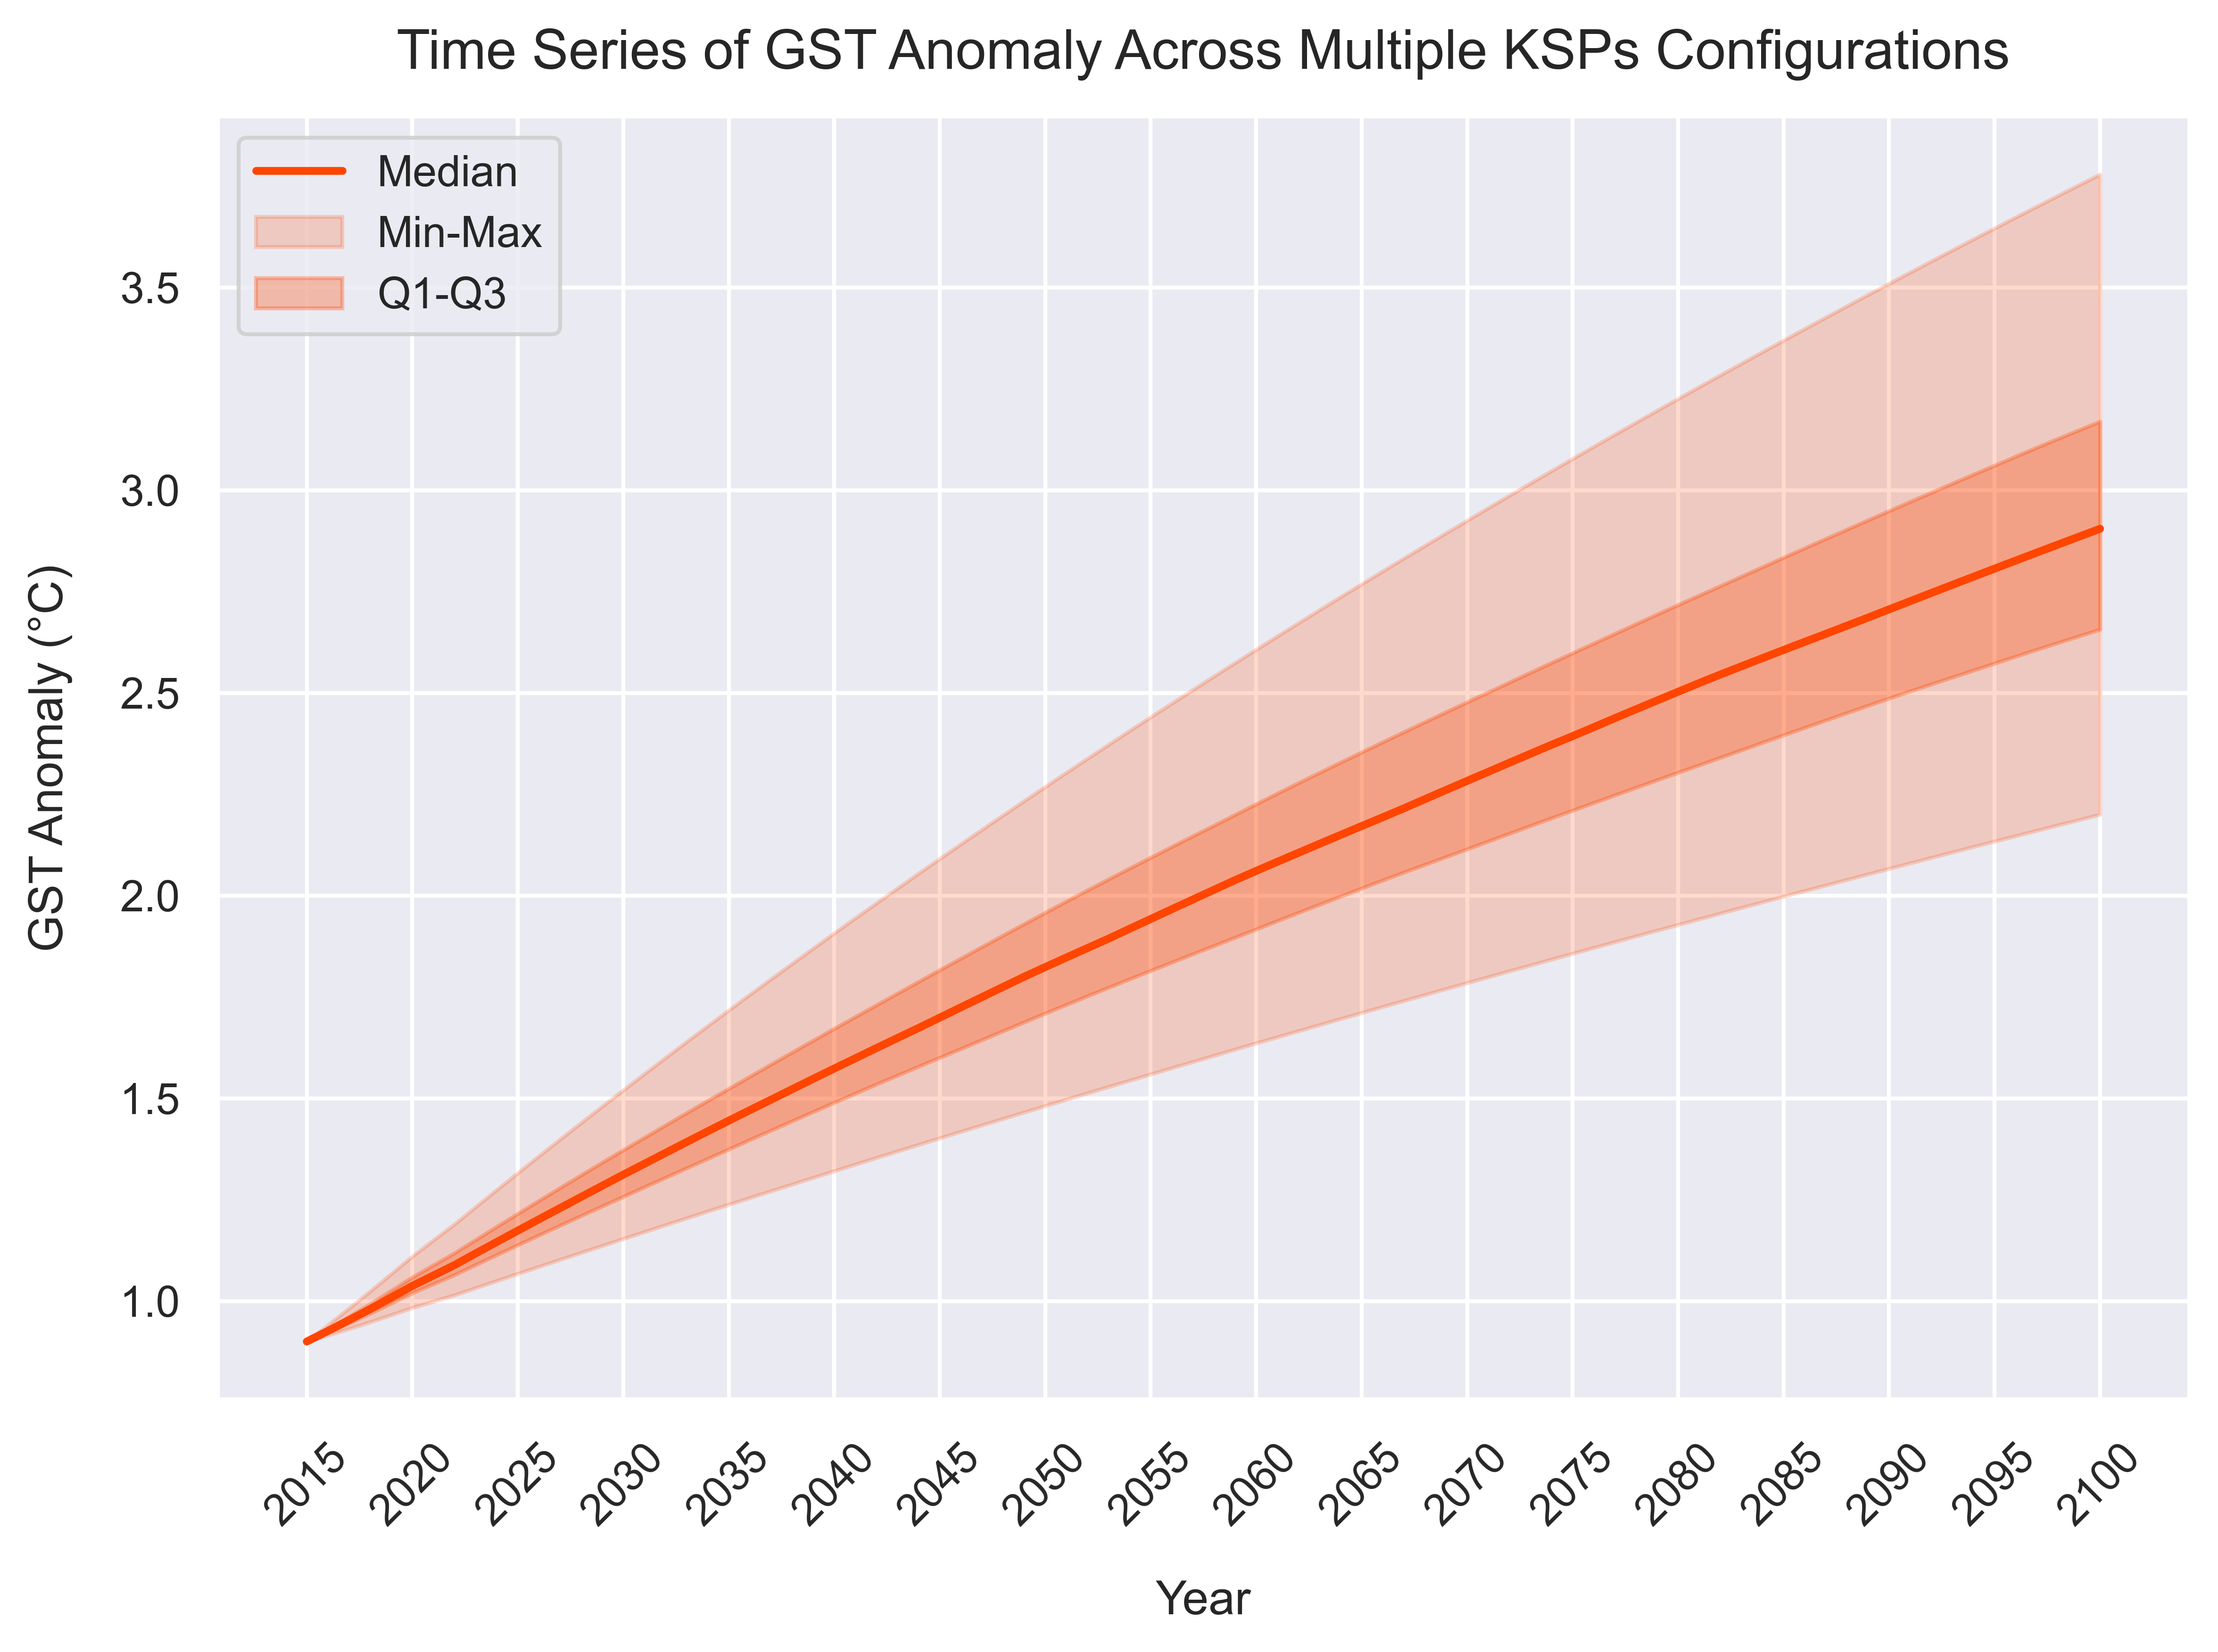

In [ ]:
gst_dataset = create_dataset(experiment_data["Global Temperature Dataset"])
create_time_series_plot(gst_dataset, {
    "color": "#FF4500",
    "yLabel": "GST Anomaly (°C)",
    "title": "Time Series of GST Anomaly Across Multiple KSPs Configurations",
    "legend_loc": "upper left"
})

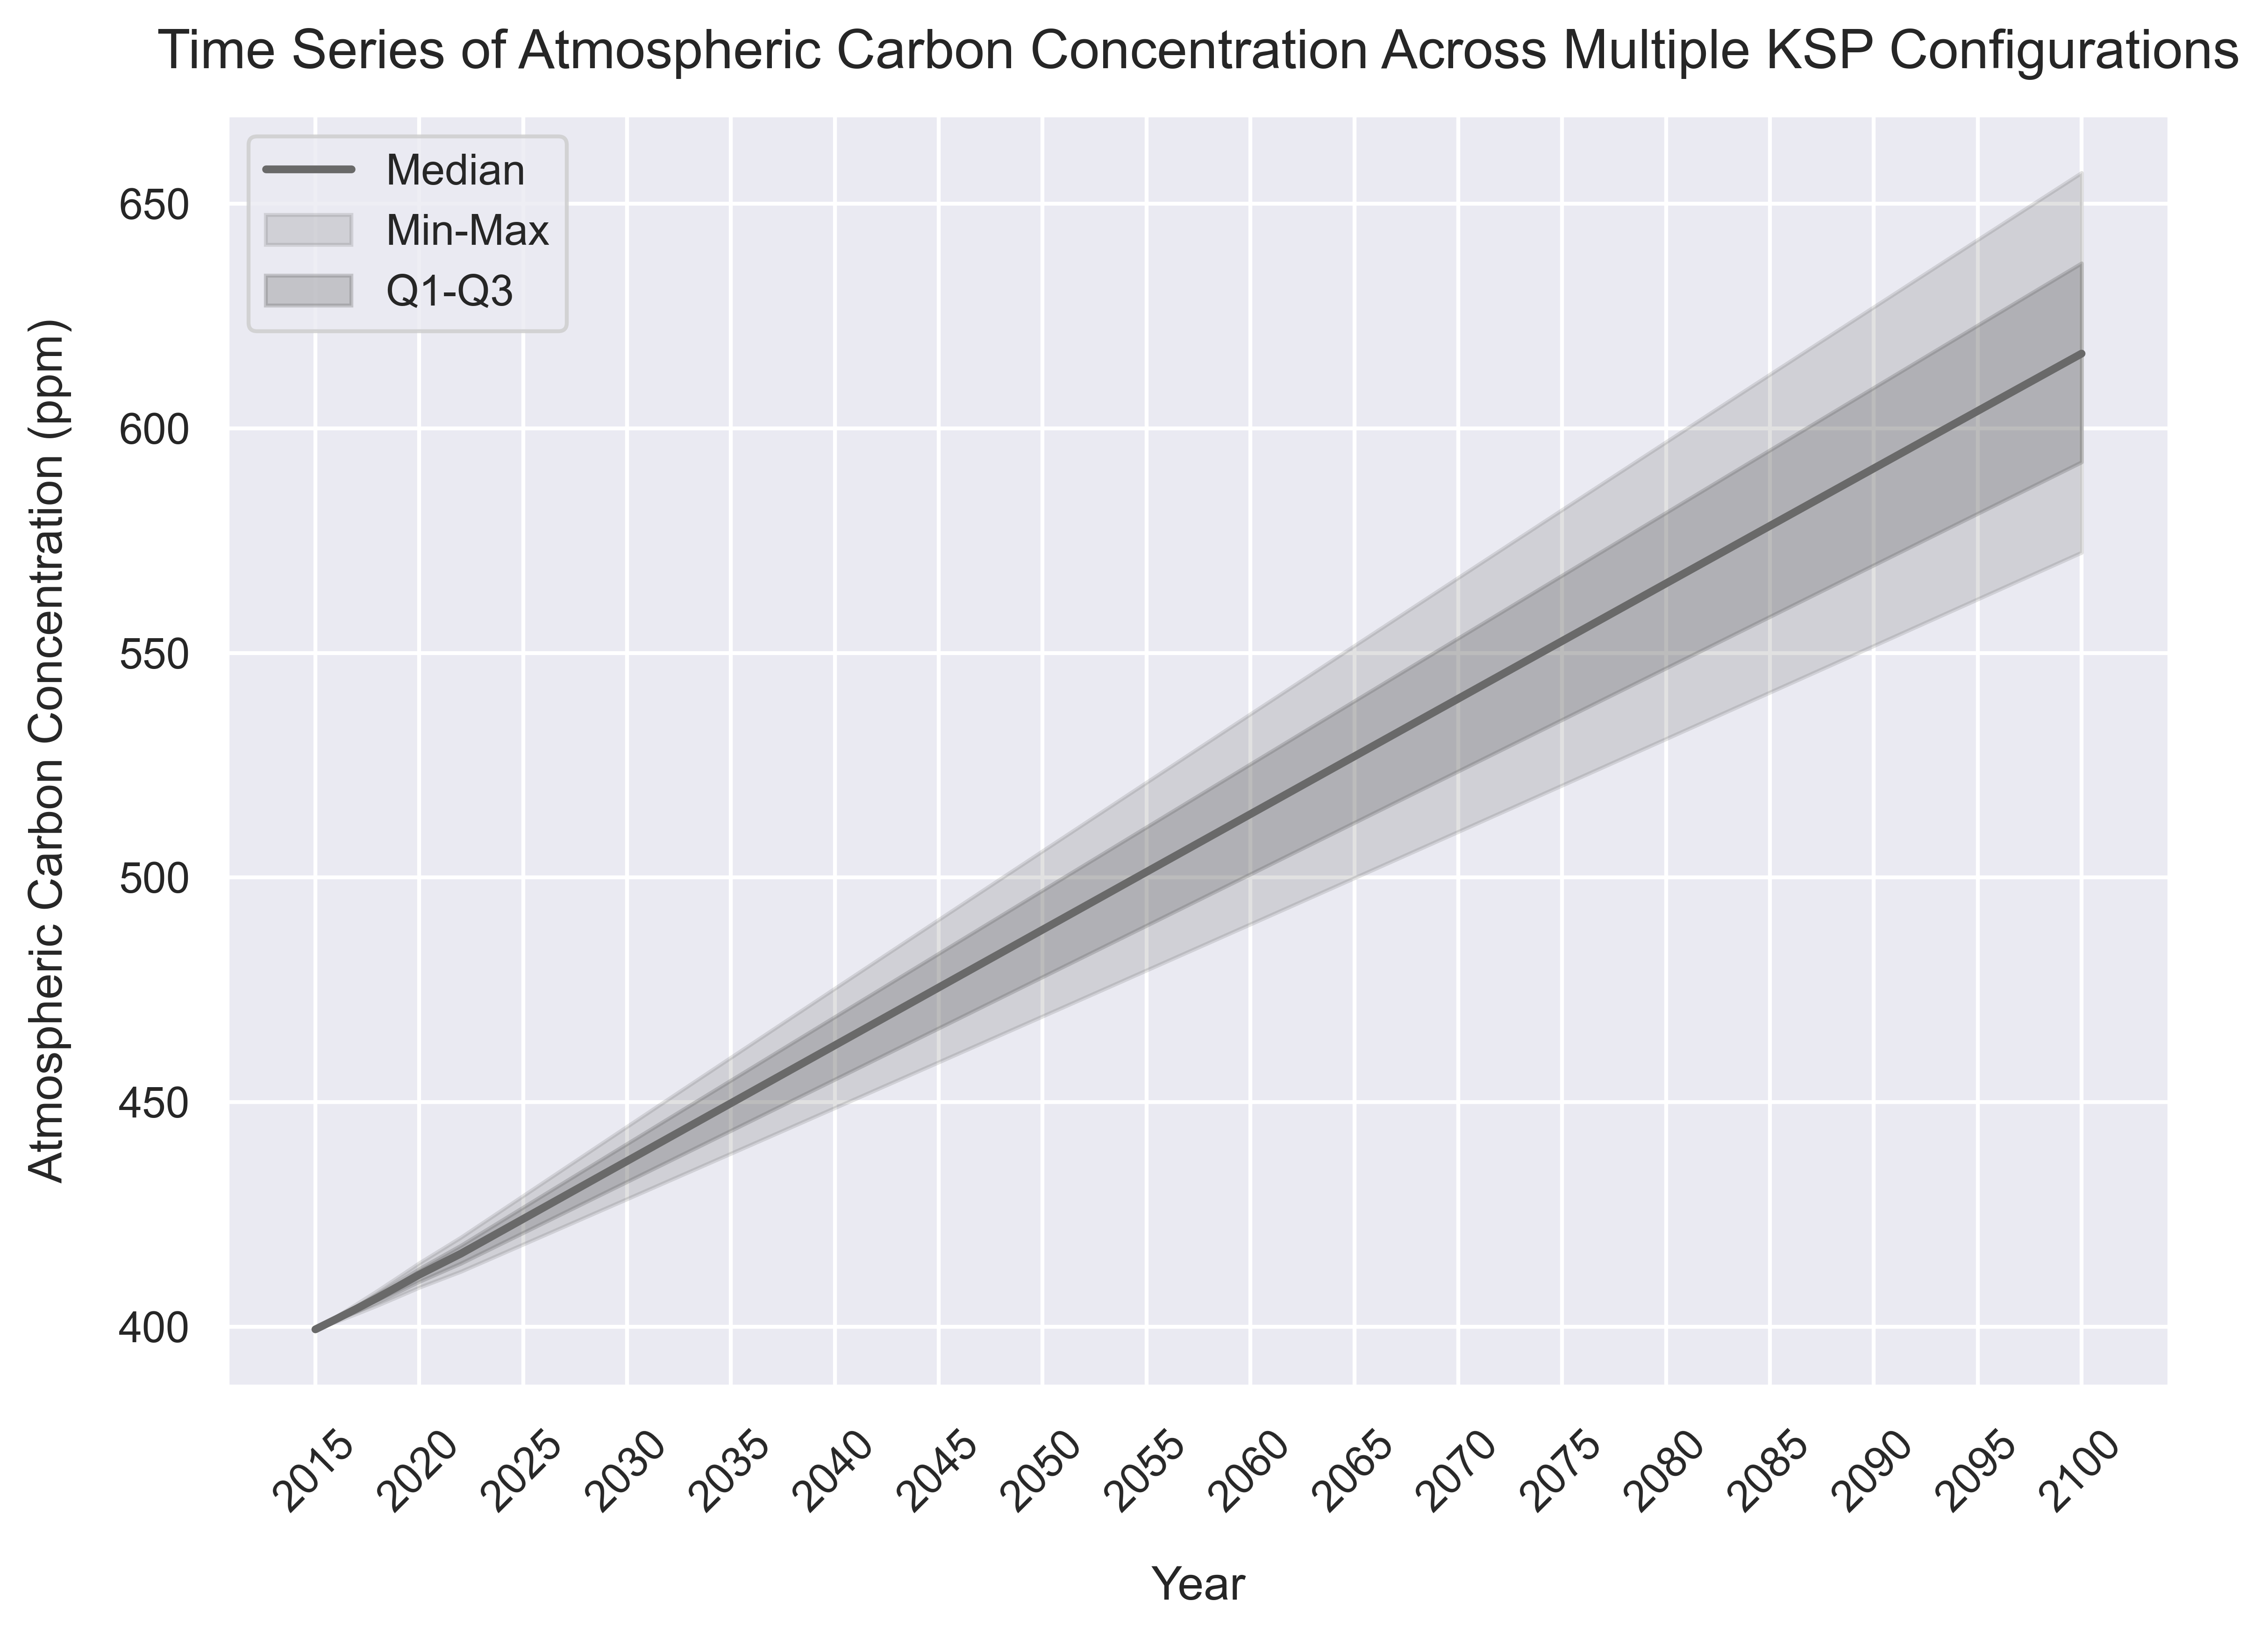

In [ ]:
emisison = create_dataset(experiment_data["Global Emission PPM Dataset"])
create_time_series_plot(emisison, {
    "color": "#696969",
    "yLabel": "Atmospheric Carbon Concentration (ppm)",
    "title": "Time Series of Atmospheric Carbon Concentration Across Multiple KSP Configurations",
    "legend_loc": "upper left"
})

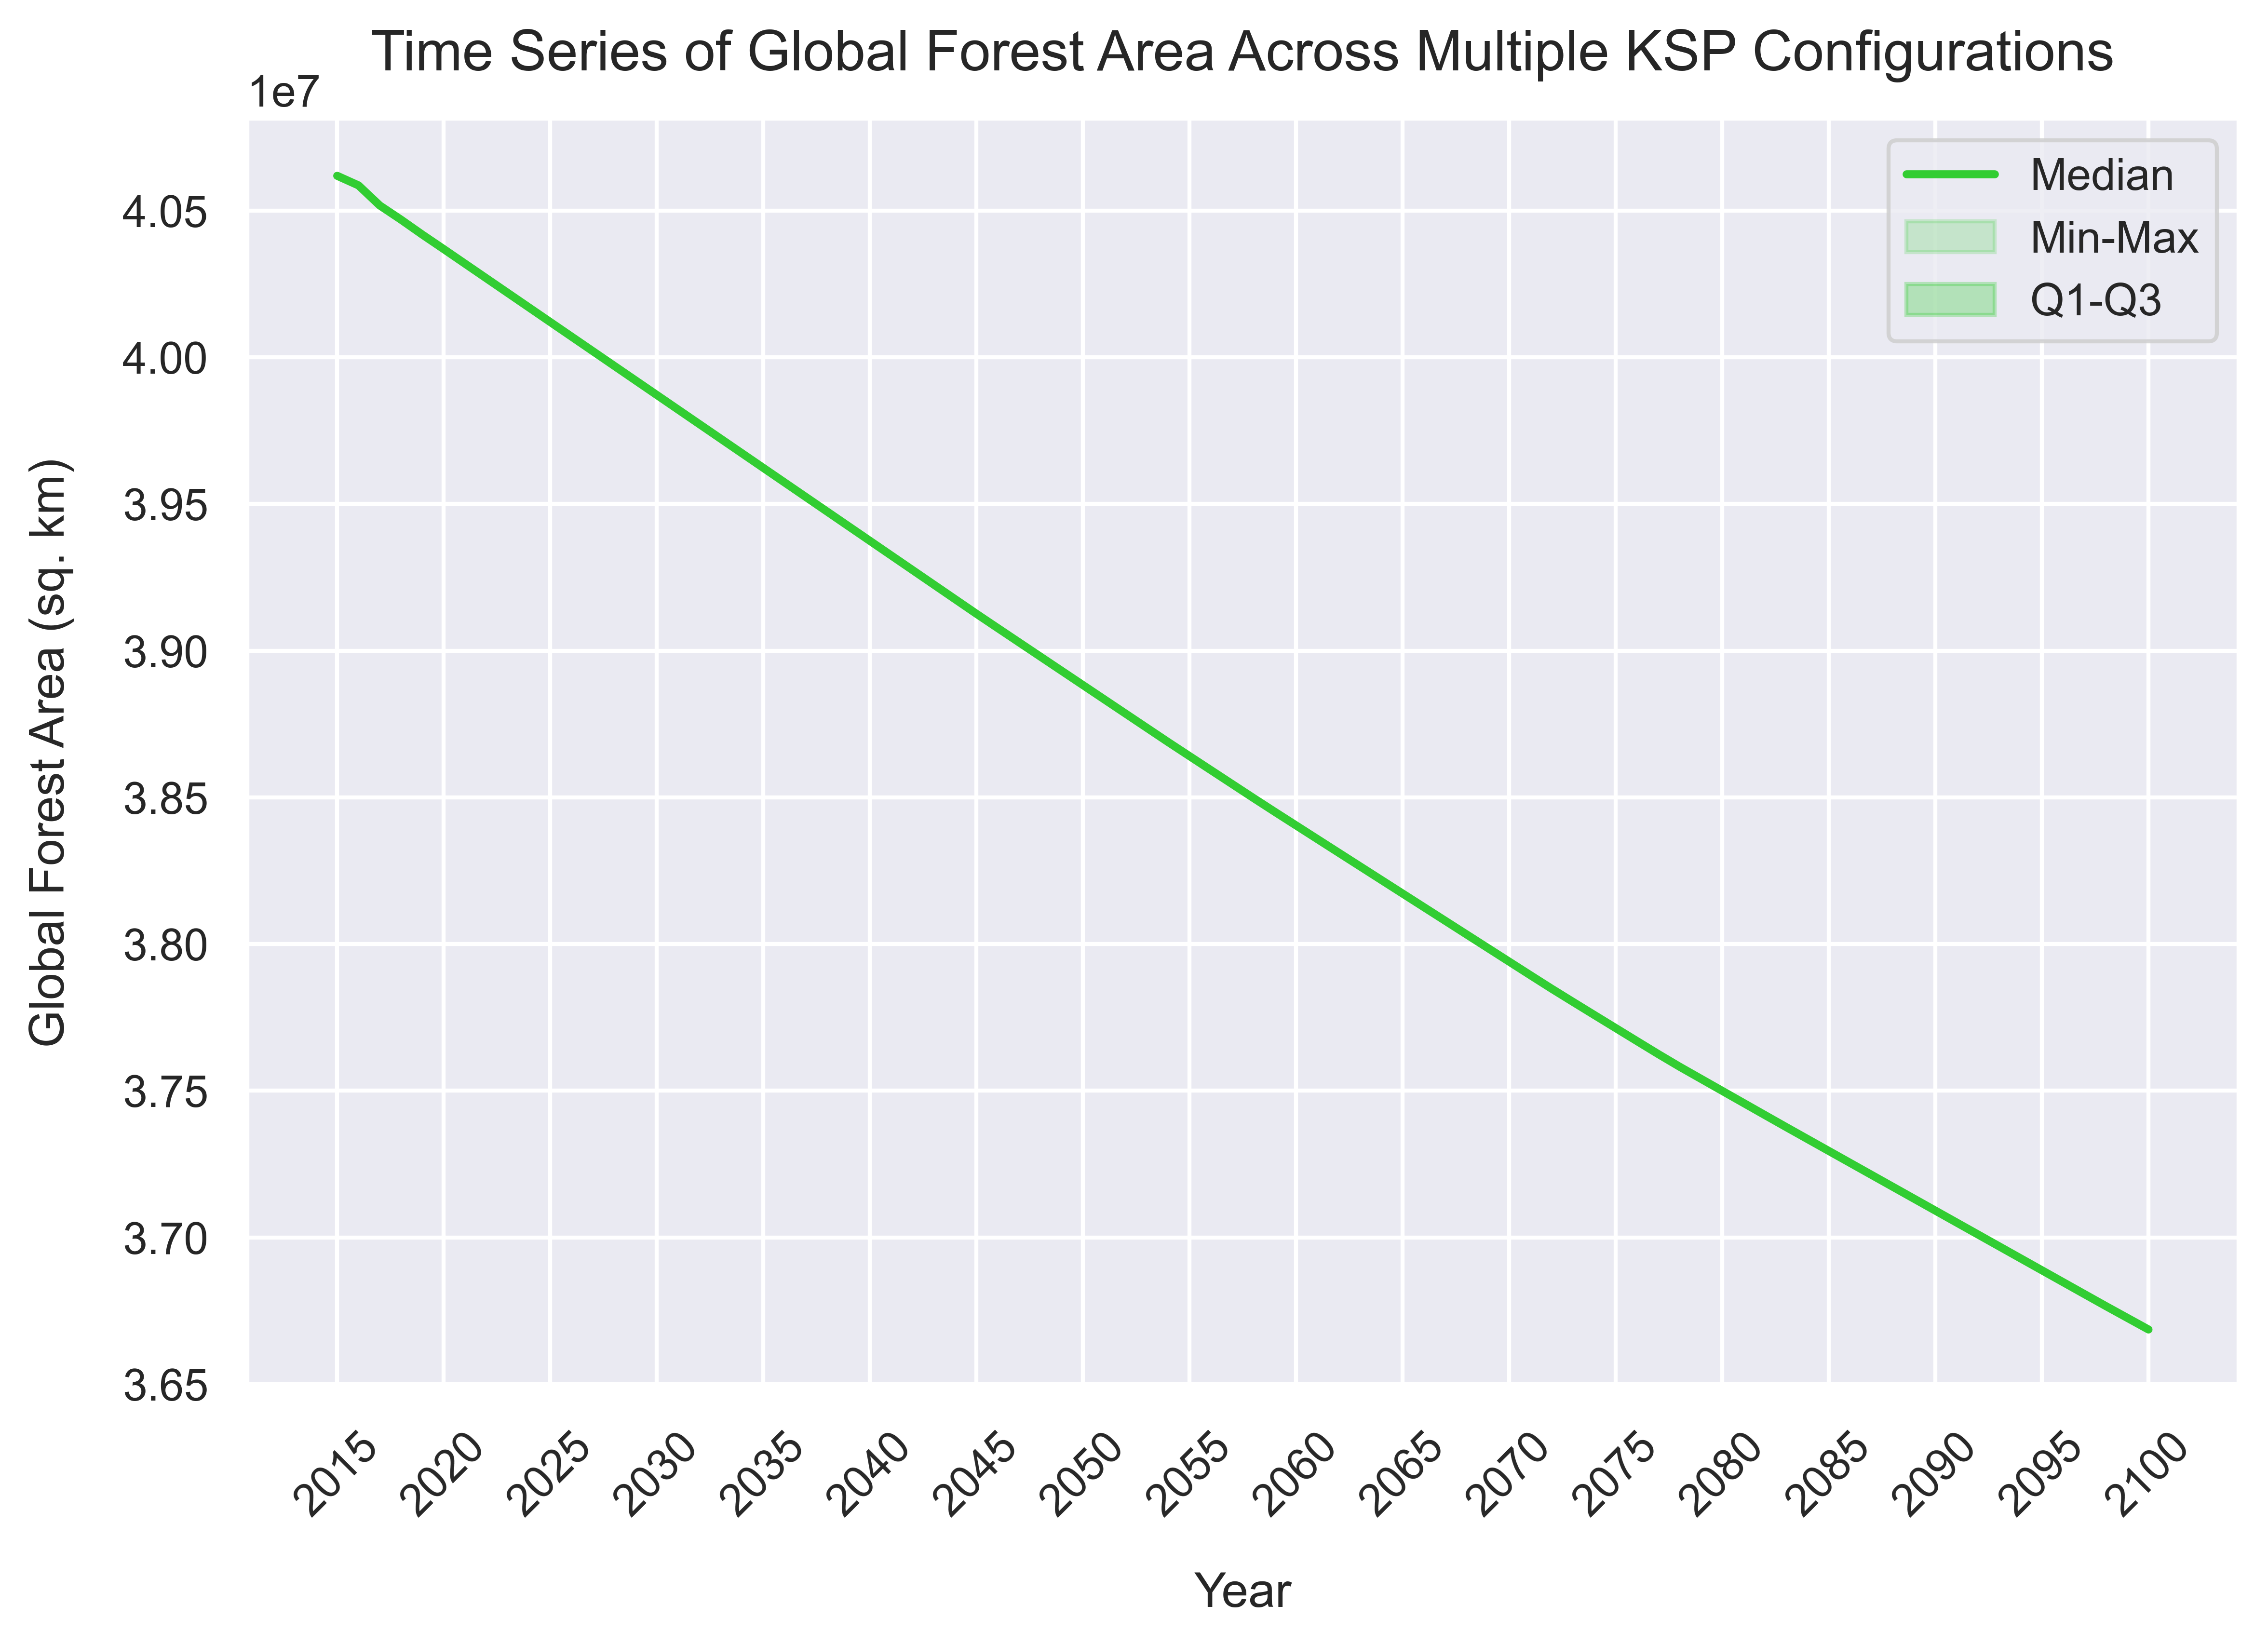

In [257]:
forest = create_dataset(experiment_data["Global Forest Area Dataset"])
create_time_series_plot(forest, {
    "color": "#32CD32",
    "yLabel": "Global Forest Area (sq. km)",
    "title": "Time Series of Global Forest Area Across Multiple KSP Configurations",
    "legend_loc": "upper right"
})

Temperature 2024  Temperature 2050  Temperature 2100  \
Unnamed: 0                                                             
Minimum                 1.067403          1.497596          2.214460   
First quartile          1.138234          1.731671          2.674698   
Median                  1.173631          1.849127          2.926167   
Mean                    1.178056          1.861131          2.942896   
Third quartile          1.215635          1.986719          3.192583   
Maximum                 1.316062          2.304372          3.808045   

                Year Temperature Exceeds 1.5 Threshold  \
Unnamed: 0                                               
Minimum                                    2029.000000   
First quartile                             2034.000000   
Median                                     2037.000000   
Mean                                       2037.105114   
Third quartile                             2040.000000   
Maximum                                    2051.000000   

                Year Temperature Exceeds 2.0 Threshold  \
Unnamed: 0                                               
Minimum                                    2042.000000   
First quartile                             2051.000000   
Median                                     2057.000000   
Mean                                       2057.931818   
Third quartile                             2063.500000   
Maximum                                    2085.000000   

                CO2 Concentration 2024  CO2 Concentration 2050  \
Unnamed: 0                                                       
Minimum                     418.329465              471.194359   
First quartile              420.905306              480.201799   
Median                      423.738732              490.109983   
Mean                        423.738732              490.109983   
Third quartile              426.572157              500.018168   
Maximum                     429.147999              509.025608   

                CO2 Concentration 2100  CO2 Concentration 1.5 Threshold   \
Unnamed: 0                                                                 
Minimum                     574.575853                        442.997032   
First quartile              594.937378                        447.462614   
Median                      617.335056                        453.767987   
Mean                        617.335056                        455.046486   
Third quartile              639.732733                        461.975968   
Maximum                     660.094258                        471.509415   

                CO2 Concentration 2.0 Threshold   Forest Size 1.5 Threshold   \
Unnamed: 0                                                                     
Minimum                               482.953552                3.882536e+07   
First quartile                        491.914093                3.935142e+07   
Median                                504.701370                3.951632e+07   
Mean                                  507.451029                3.949211e+07   
Third quartile                        521.570336                3.966238e+07   
Maximum                               541.468610                3.989634e+07   

                Forest Size 2.0 Threshold   
Unnamed: 0                                  
Minimum                       3.728985e+07  
First quartile                3.821482e+07  
Median                        3.852908e+07  
Mean                          3.848268e+07  
Third quartile                3.880935e+07  
Maximum                       3.924991e+07

In [441]:
def plot_boxplot(col1, col2=None, col3=None, col4=None, configs=None):
    df_raw = experiment_data["Boxplot Statistics"]
    df = df_raw.set_index("Unnamed: 0")

    # Example precomputed boxplot statistics
    boxplot_stats = [
        {
            'med': df.loc["Median", col1],    # Median
            'q1':  df.loc["First quartile", col1],     # First quartile (Q1)
            'q3':  df.loc["Third quartile", col1],     # Third quartile (Q3)
            'whislo': df.loc["Minimum", col1], # Lower whisker
            'whishi':  df.loc["Maximum", col1], # Upper whisker
            'fliers': [],  # Outliers (if any)
            'label': configs["col1_label"]
        },
    ]

    if col2:
        boxplot_stats.append({
            'med': df.loc["Median", col2],    # Median
            'q1':  df.loc["First quartile", col2],     # First quartile (Q1)
            'q3':  df.loc["Third quartile", col2],     # Third quartile (Q3)
            'whislo': df.loc["Minimum", col2], # Lower whisker
            'whishi':  df.loc["Maximum", col2], # Upper whisker
            'fliers': [],  # Outliers (if any)
            'label': configs["col2_label"]
        })
    if col3:
        boxplot_stats.append({
            'med': df.loc["Median", col3],    # Median
            'q1':  df.loc["First quartile", col3],     # First quartile (Q1)
            'q3':  df.loc["Third quartile", col3],     # Third quartile (Q3)
            'whislo': df.loc["Minimum", col3], # Lower whisker
            'whishi':  df.loc["Maximum", col3], # Upper whisker
            'fliers': [],  # Outliers (if any)
            'label': configs["col3_label"]
        })
    if col4:
        boxplot_stats.append({
            'med': df.loc["Median", col4],    # Median
            'q1':  df.loc["First quartile", col4],     # First quartile (Q1)
            'q3':  df.loc["Third quartile", col4],     # Third quartile (Q3)
            'whislo': df.loc["Minimum", col4], # Lower whisker
            'whishi':  df.loc["Maximum", col4], # Upper whisker
            'fliers': [],  # Outliers (if any)
            'label': configs["col4_label"]
        })

    sns.set_style("darkgrid")
    sns.despine(trim=True) 

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6), dpi=600)


    # Plot the precomputed boxplot using ax.bxp()
    ax.bxp(boxplot_stats, showfliers=True, patch_artist=True, 
            boxprops=dict(facecolor=configs["facecolor"], edgecolor=configs["facecolor"], linewidth=1.5, alpha=0.5), 
            medianprops=dict(color=configs["facecolor"], linewidth=1.5),
            whiskerprops=dict(color=configs["facecolor"], linewidth=1.5, alpha=0.5),
            capprops=dict(color=configs["facecolor"], linewidth=1.5, alpha=0.5))


    # Formatting
    ax.set_ylabel(configs["yLabel"], labelpad=12)
    ax.set_title(configs["title"],  fontsize=14, pad=12)

    y_min, y_max = ax.get_ylim()
    if configs["int_x"]:
        y_min = int(np.floor(y_min))
        y_max = int(np.ceil(y_max))
        ax.set_yticks(range(y_min, y_max + 1, max(1, (y_max - y_min) // 12)))
    else: 
        ax.set_yticks(np.linspace(y_min, y_max, num=12)) 
    # Round limits to nearest integer
    
    # Show plot
    plt.show()

<Figure size 640x480 with 0 Axes>

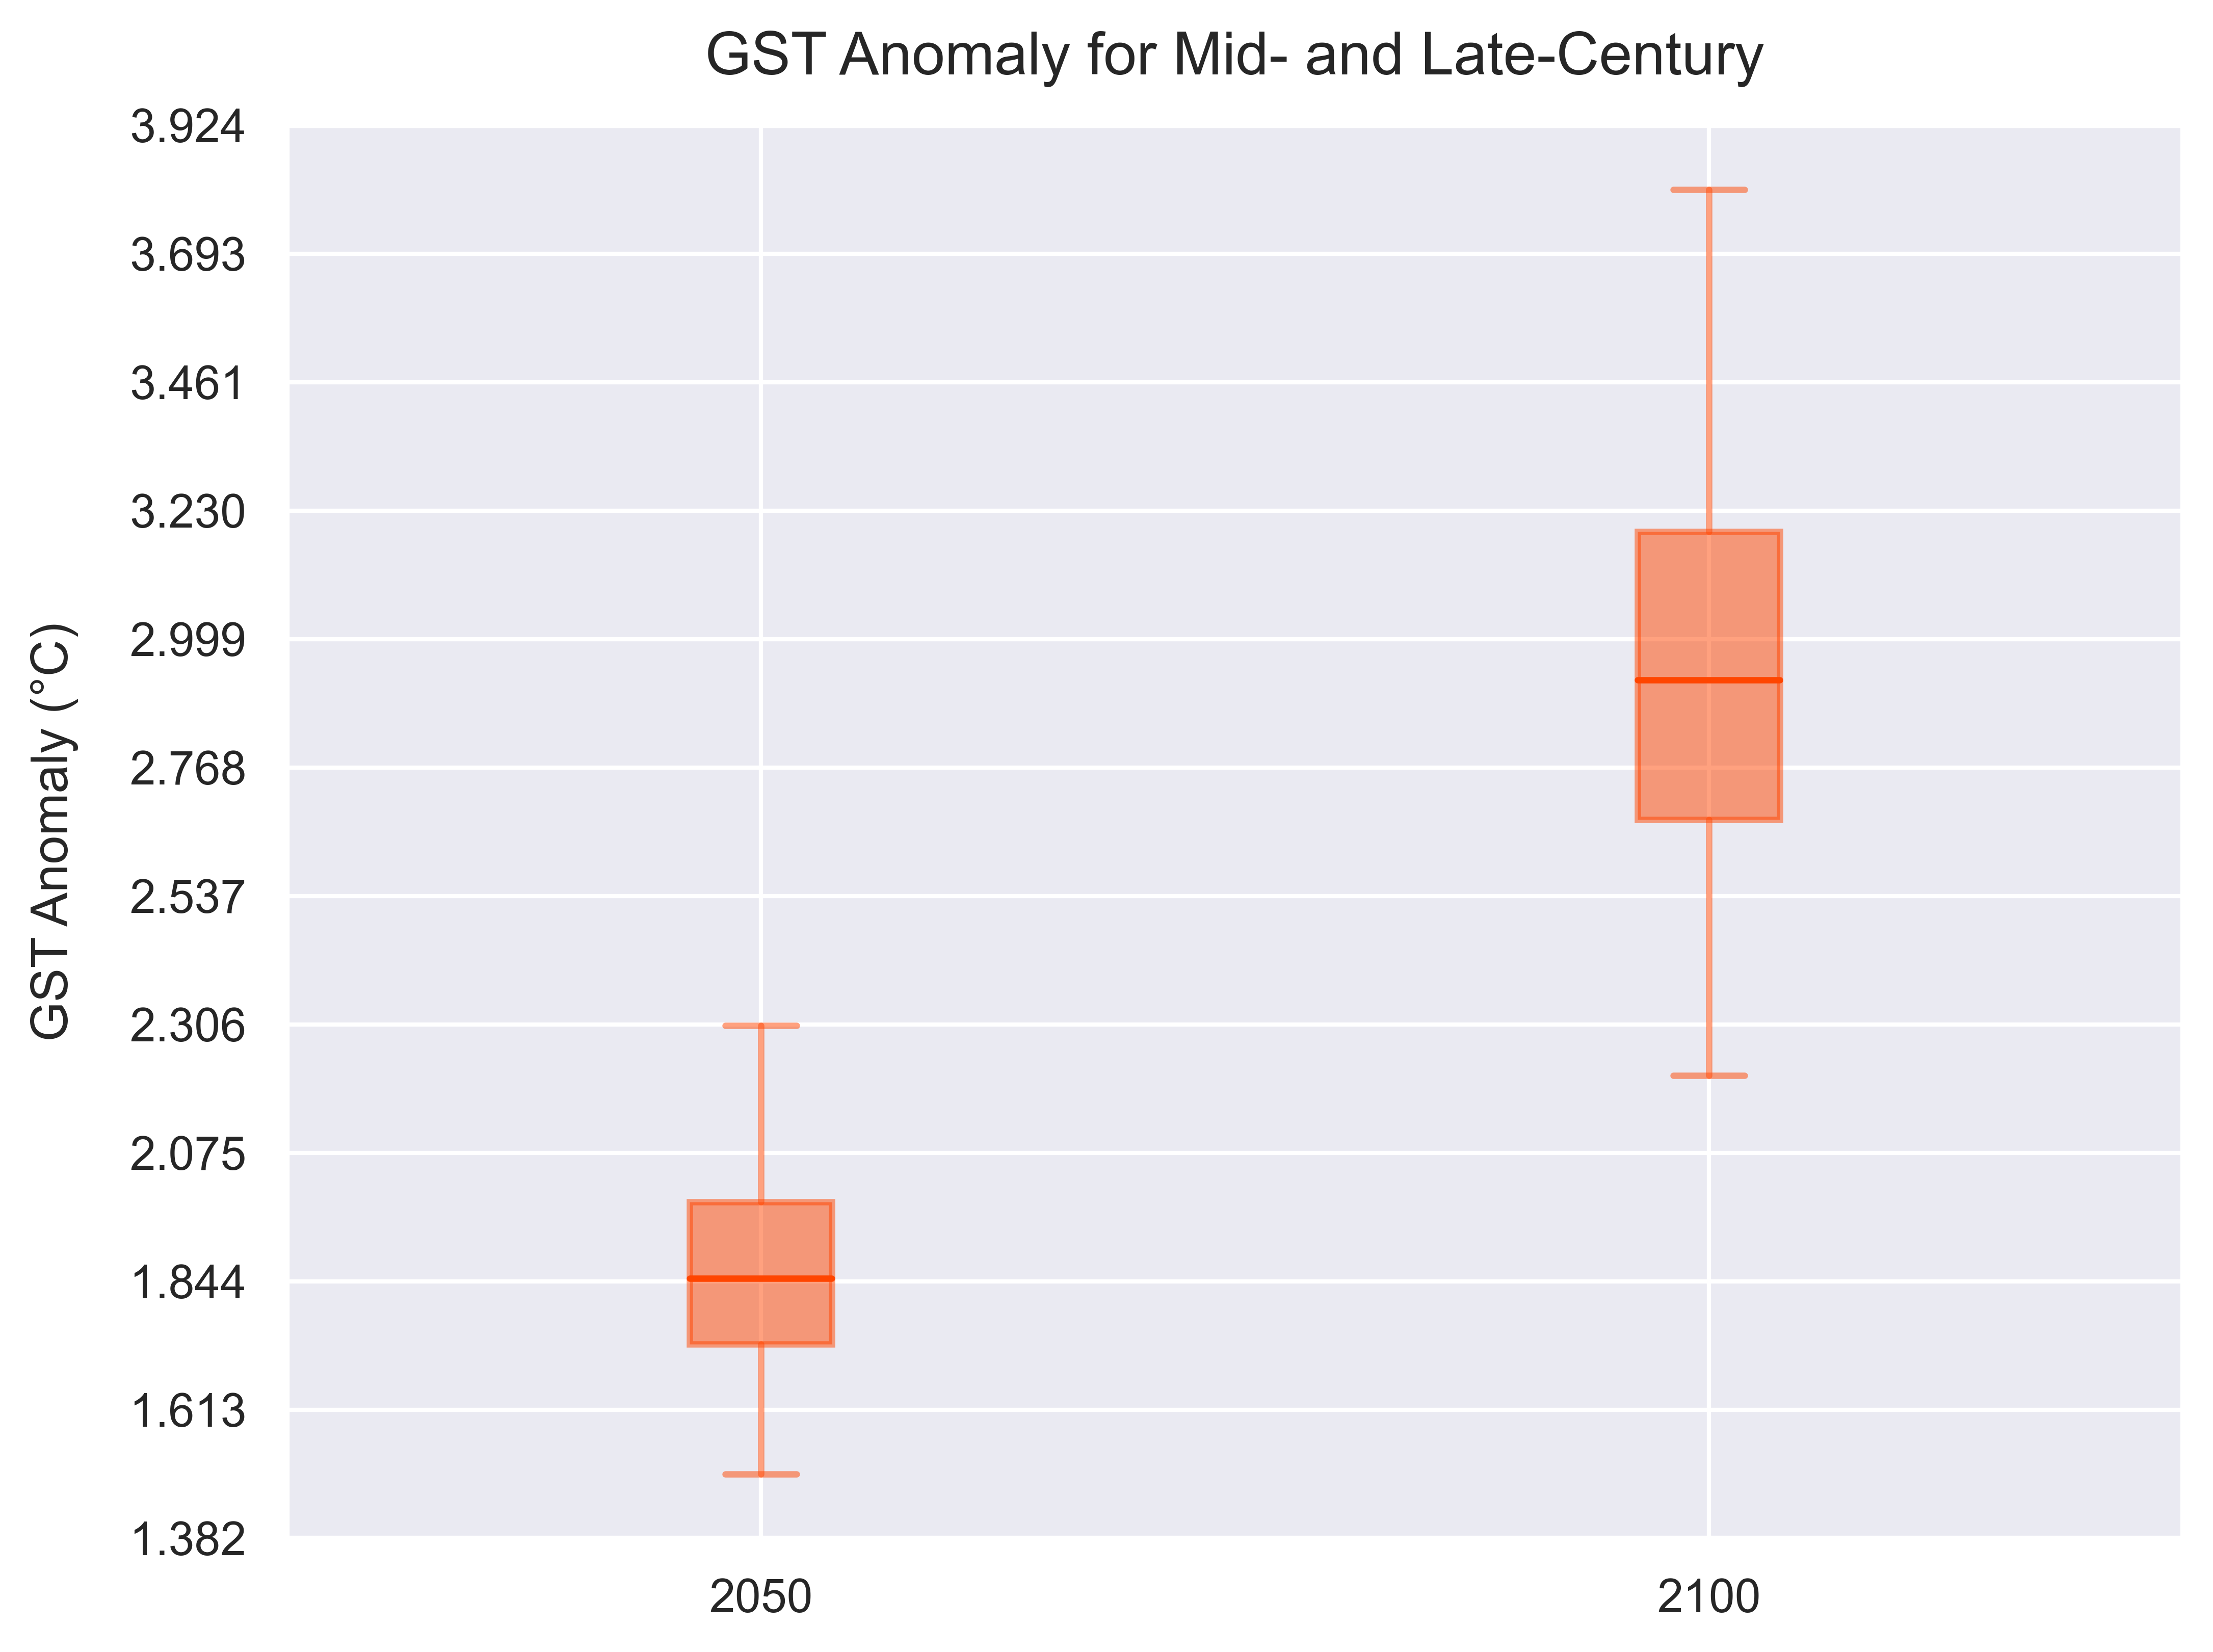

In [442]:
plot_boxplot("Temperature 2050", "Temperature 2100", configs={
    "yLabel": "GST Anomaly (°C)",
    "title": "GST Anomaly for Mid- and Late-Century",
    "facecolor": "#FF4500",
    "col1_label": "2050",
    "col2_label": "2100",
    "int_x": False
})

<Figure size 640x480 with 0 Axes>

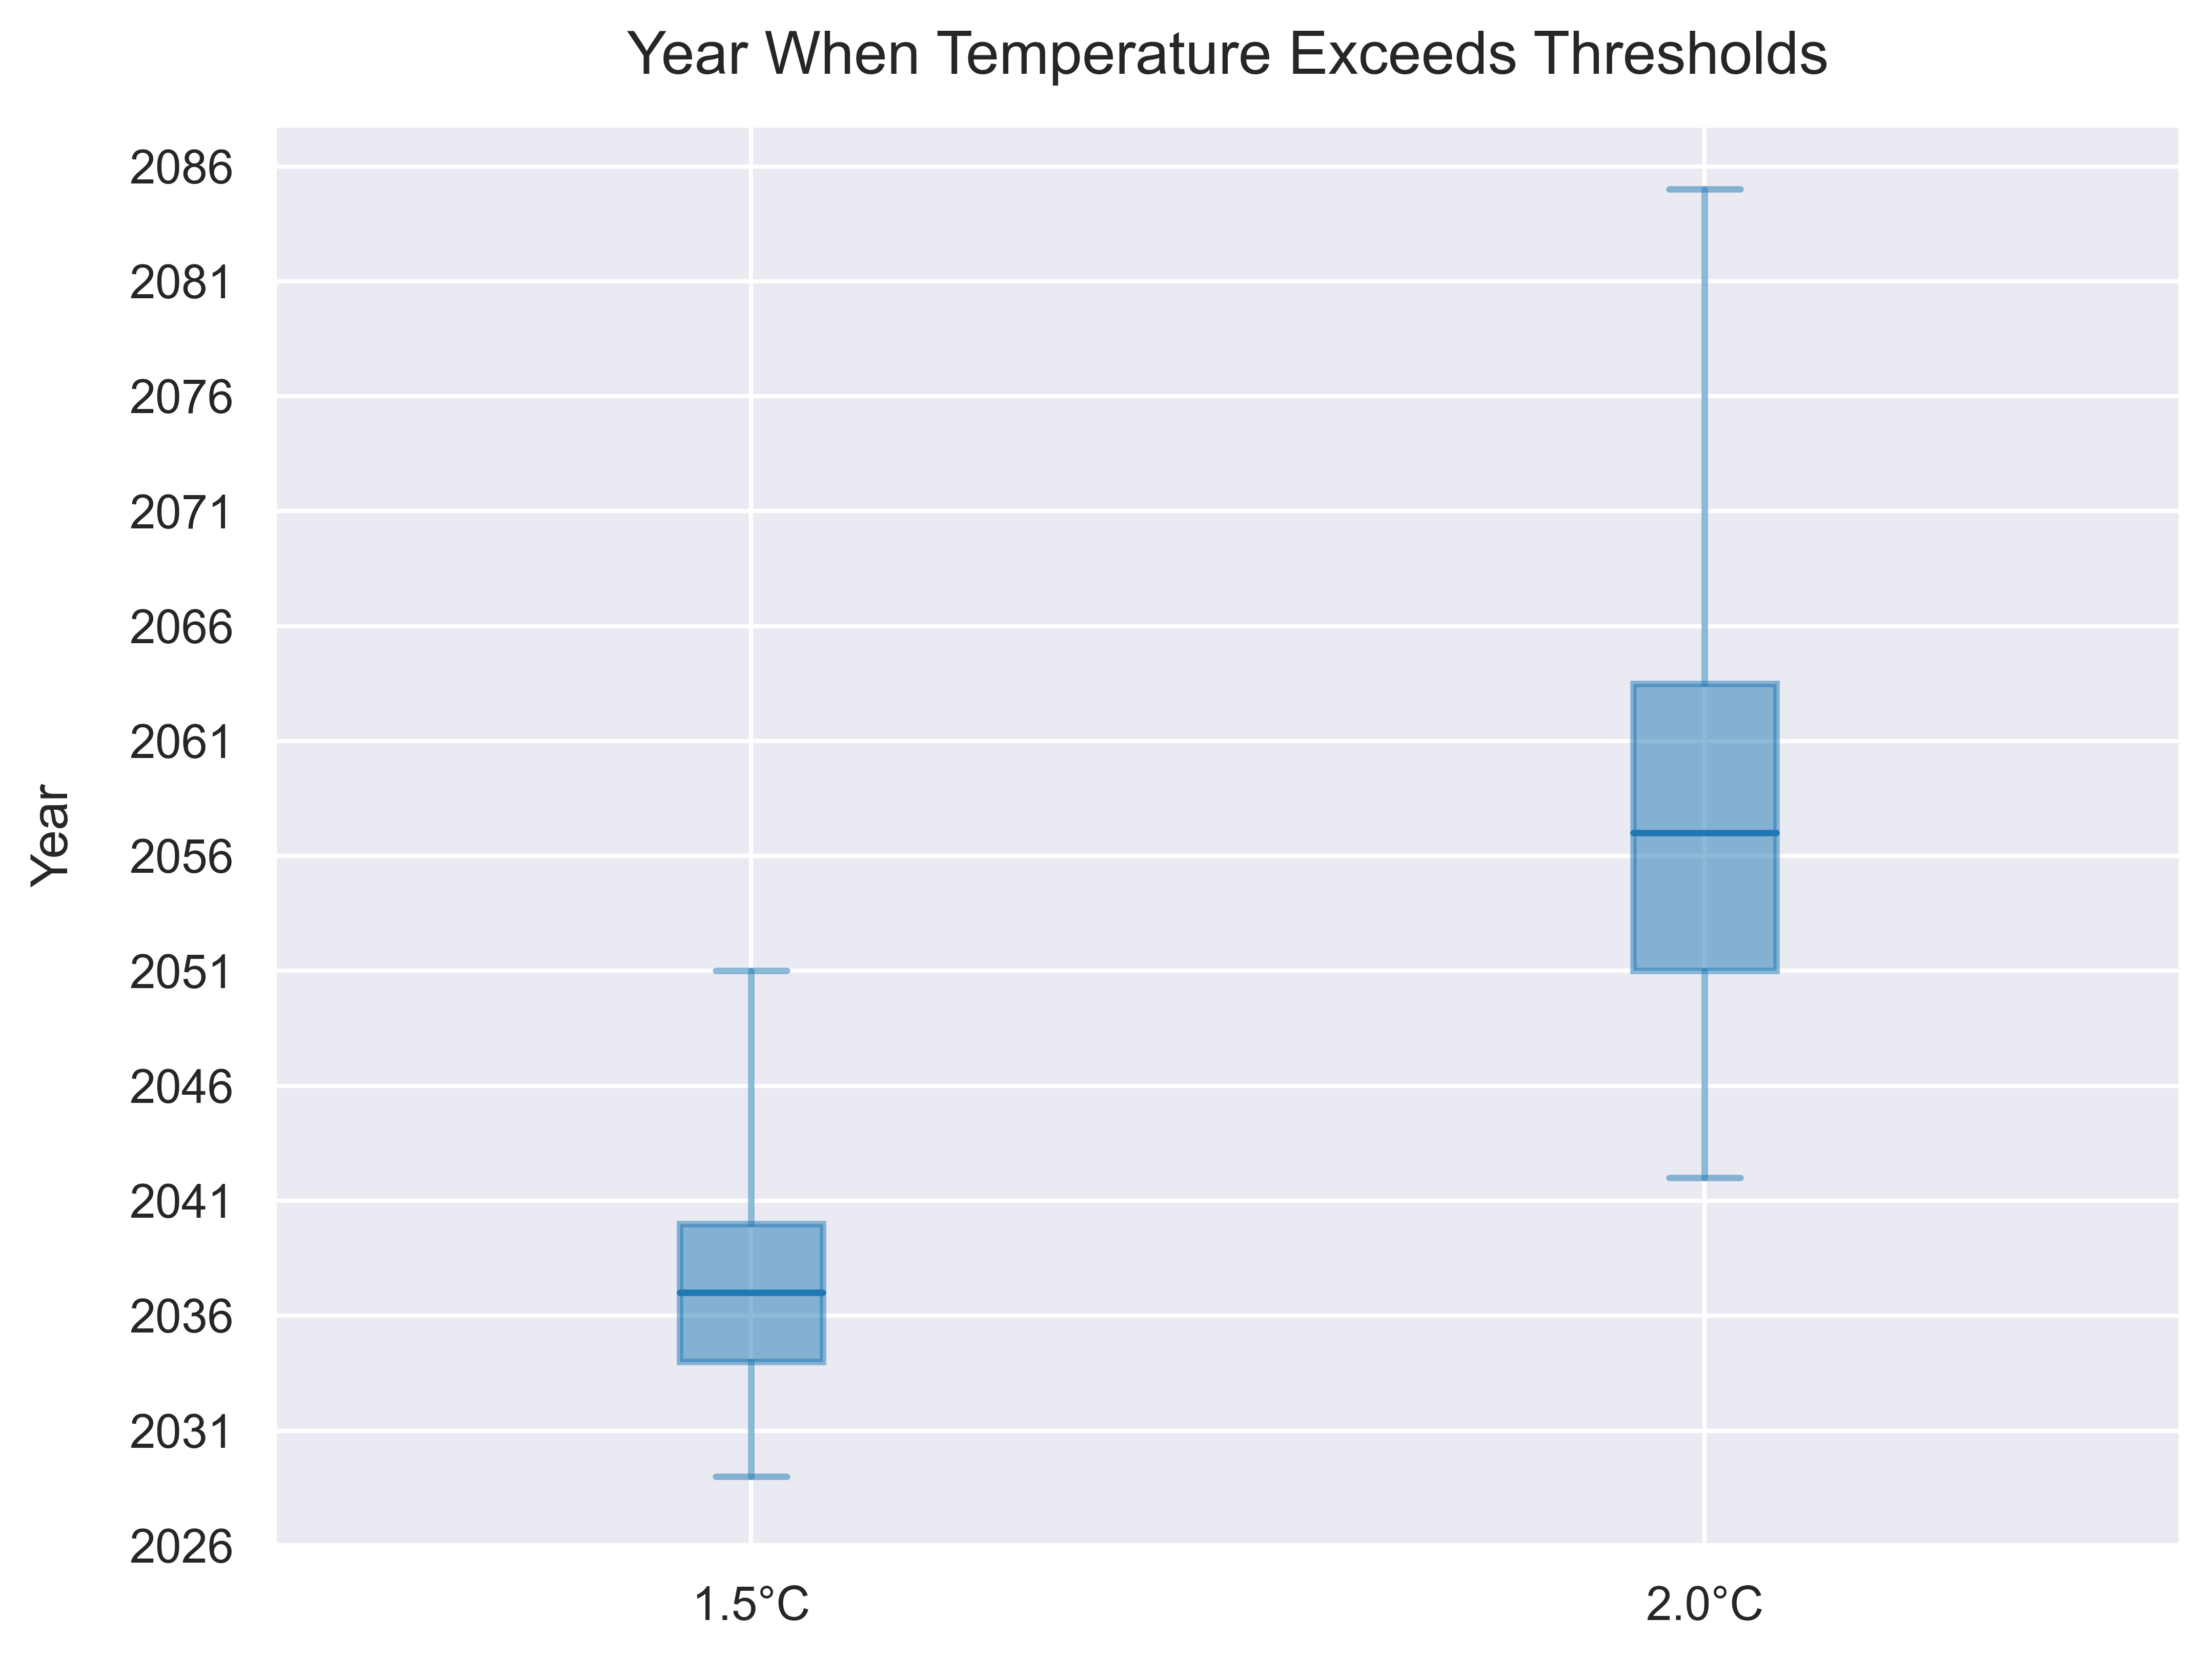

In [443]:
plot_boxplot("Year Temperature Exceeds 1.5 Threshold", "Year Temperature Exceeds 2.0 Threshold", configs={
    "yLabel": "Year",
    "title": "Year When Temperature Exceeds Thresholds",
    "facecolor": "#1f77b4",
    "col1_label": "1.5°C",
    "col2_label": "2.0°C",
    "int_x": True
})

<Figure size 640x480 with 0 Axes>

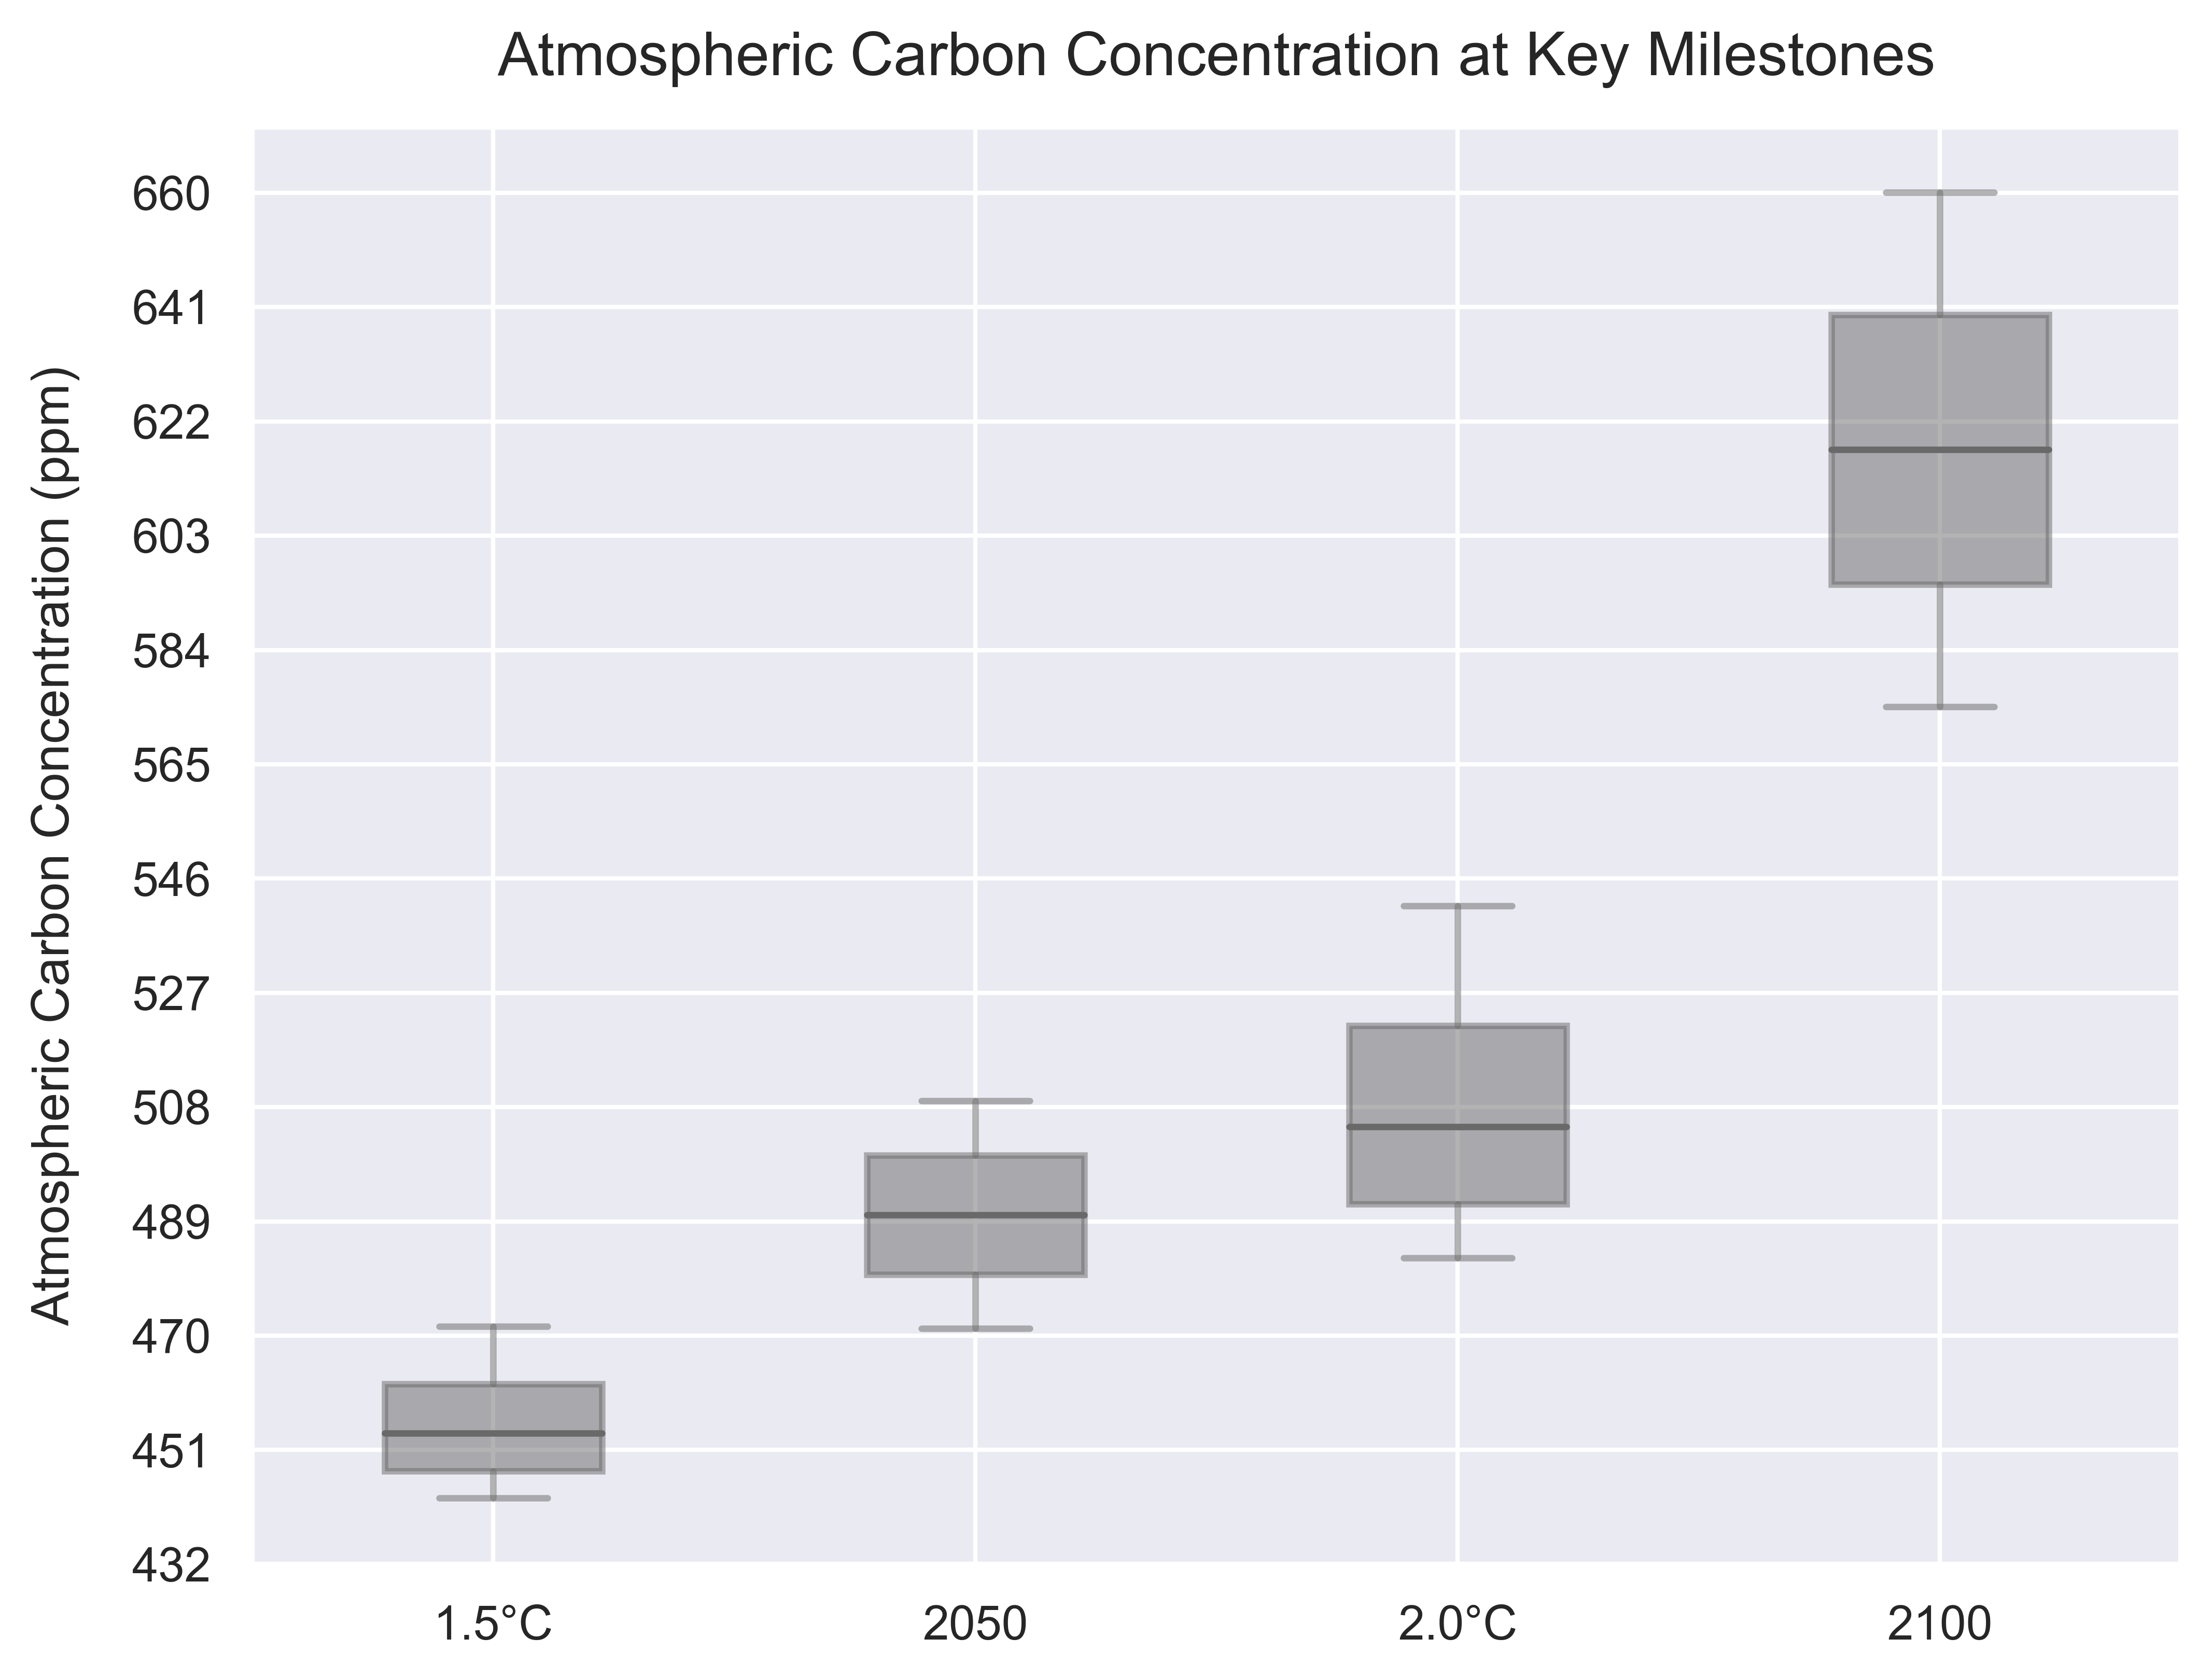

In [444]:
plot_boxplot("CO2 Concentration 1.5 Threshold ", "CO2 Concentration 2050", "CO2 Concentration 2.0 Threshold ", "CO2 Concentration 2100", configs={
    "yLabel": "Atmospheric Carbon Concentration (ppm)",
    "title": "Atmospheric Carbon Concentration at Key Milestones",
    "facecolor": "#696969",
    "col1_label": "1.5°C",
    "col2_label": "2050",
    "col3_label": "2.0°C",
    "col4_label": "2100",
    "int_x": True
})

	# CO2 Concentration 2100	CO2 Concentration 1.5 Threshold	CO2 Concentration 2.0 Threshold

<Figure size 640x480 with 0 Axes>

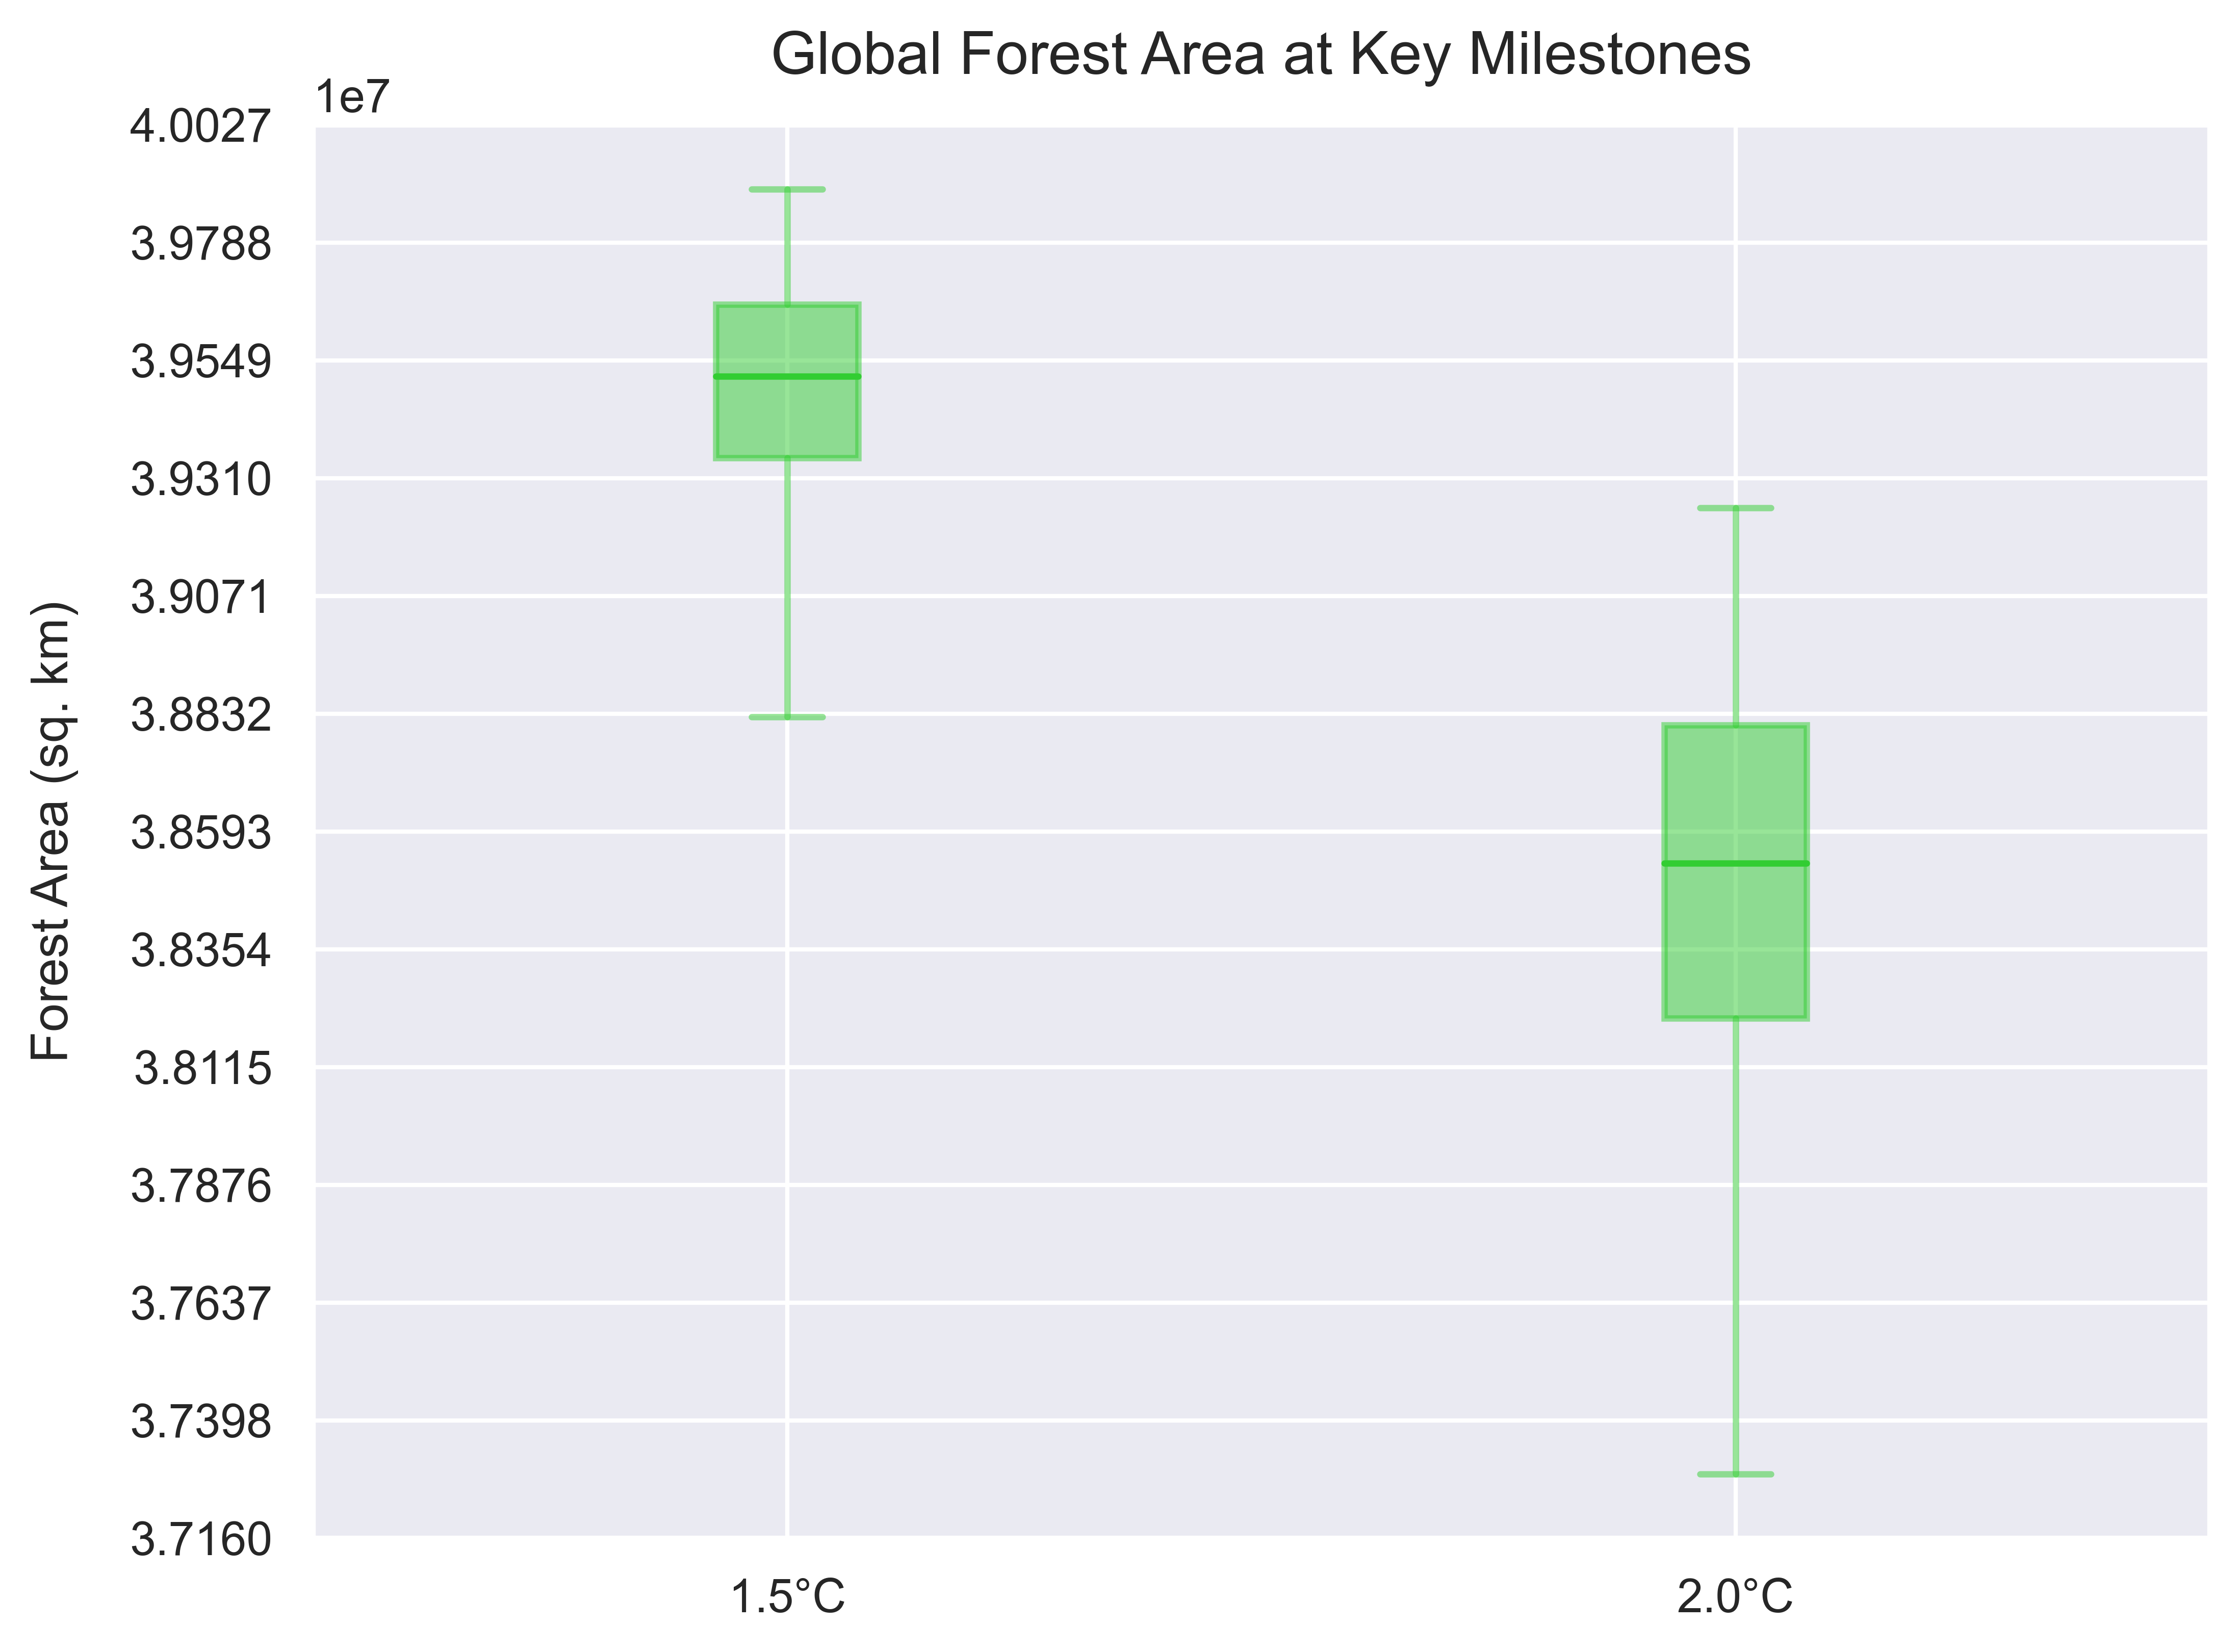

In [445]:
plot_boxplot("Forest Size 1.5 Threshold ", "Forest Size 2.0 Threshold ", configs={
    "yLabel": "Forest Area (sq. km)",
    "title": "Global Forest Area at Key Milestones",
    "facecolor": "#32CD32",
    "col1_label": "1.5°C",
    "col2_label": "2.0°C",
    "int_x": True
})


<Figure size 640x480 with 0 Axes>

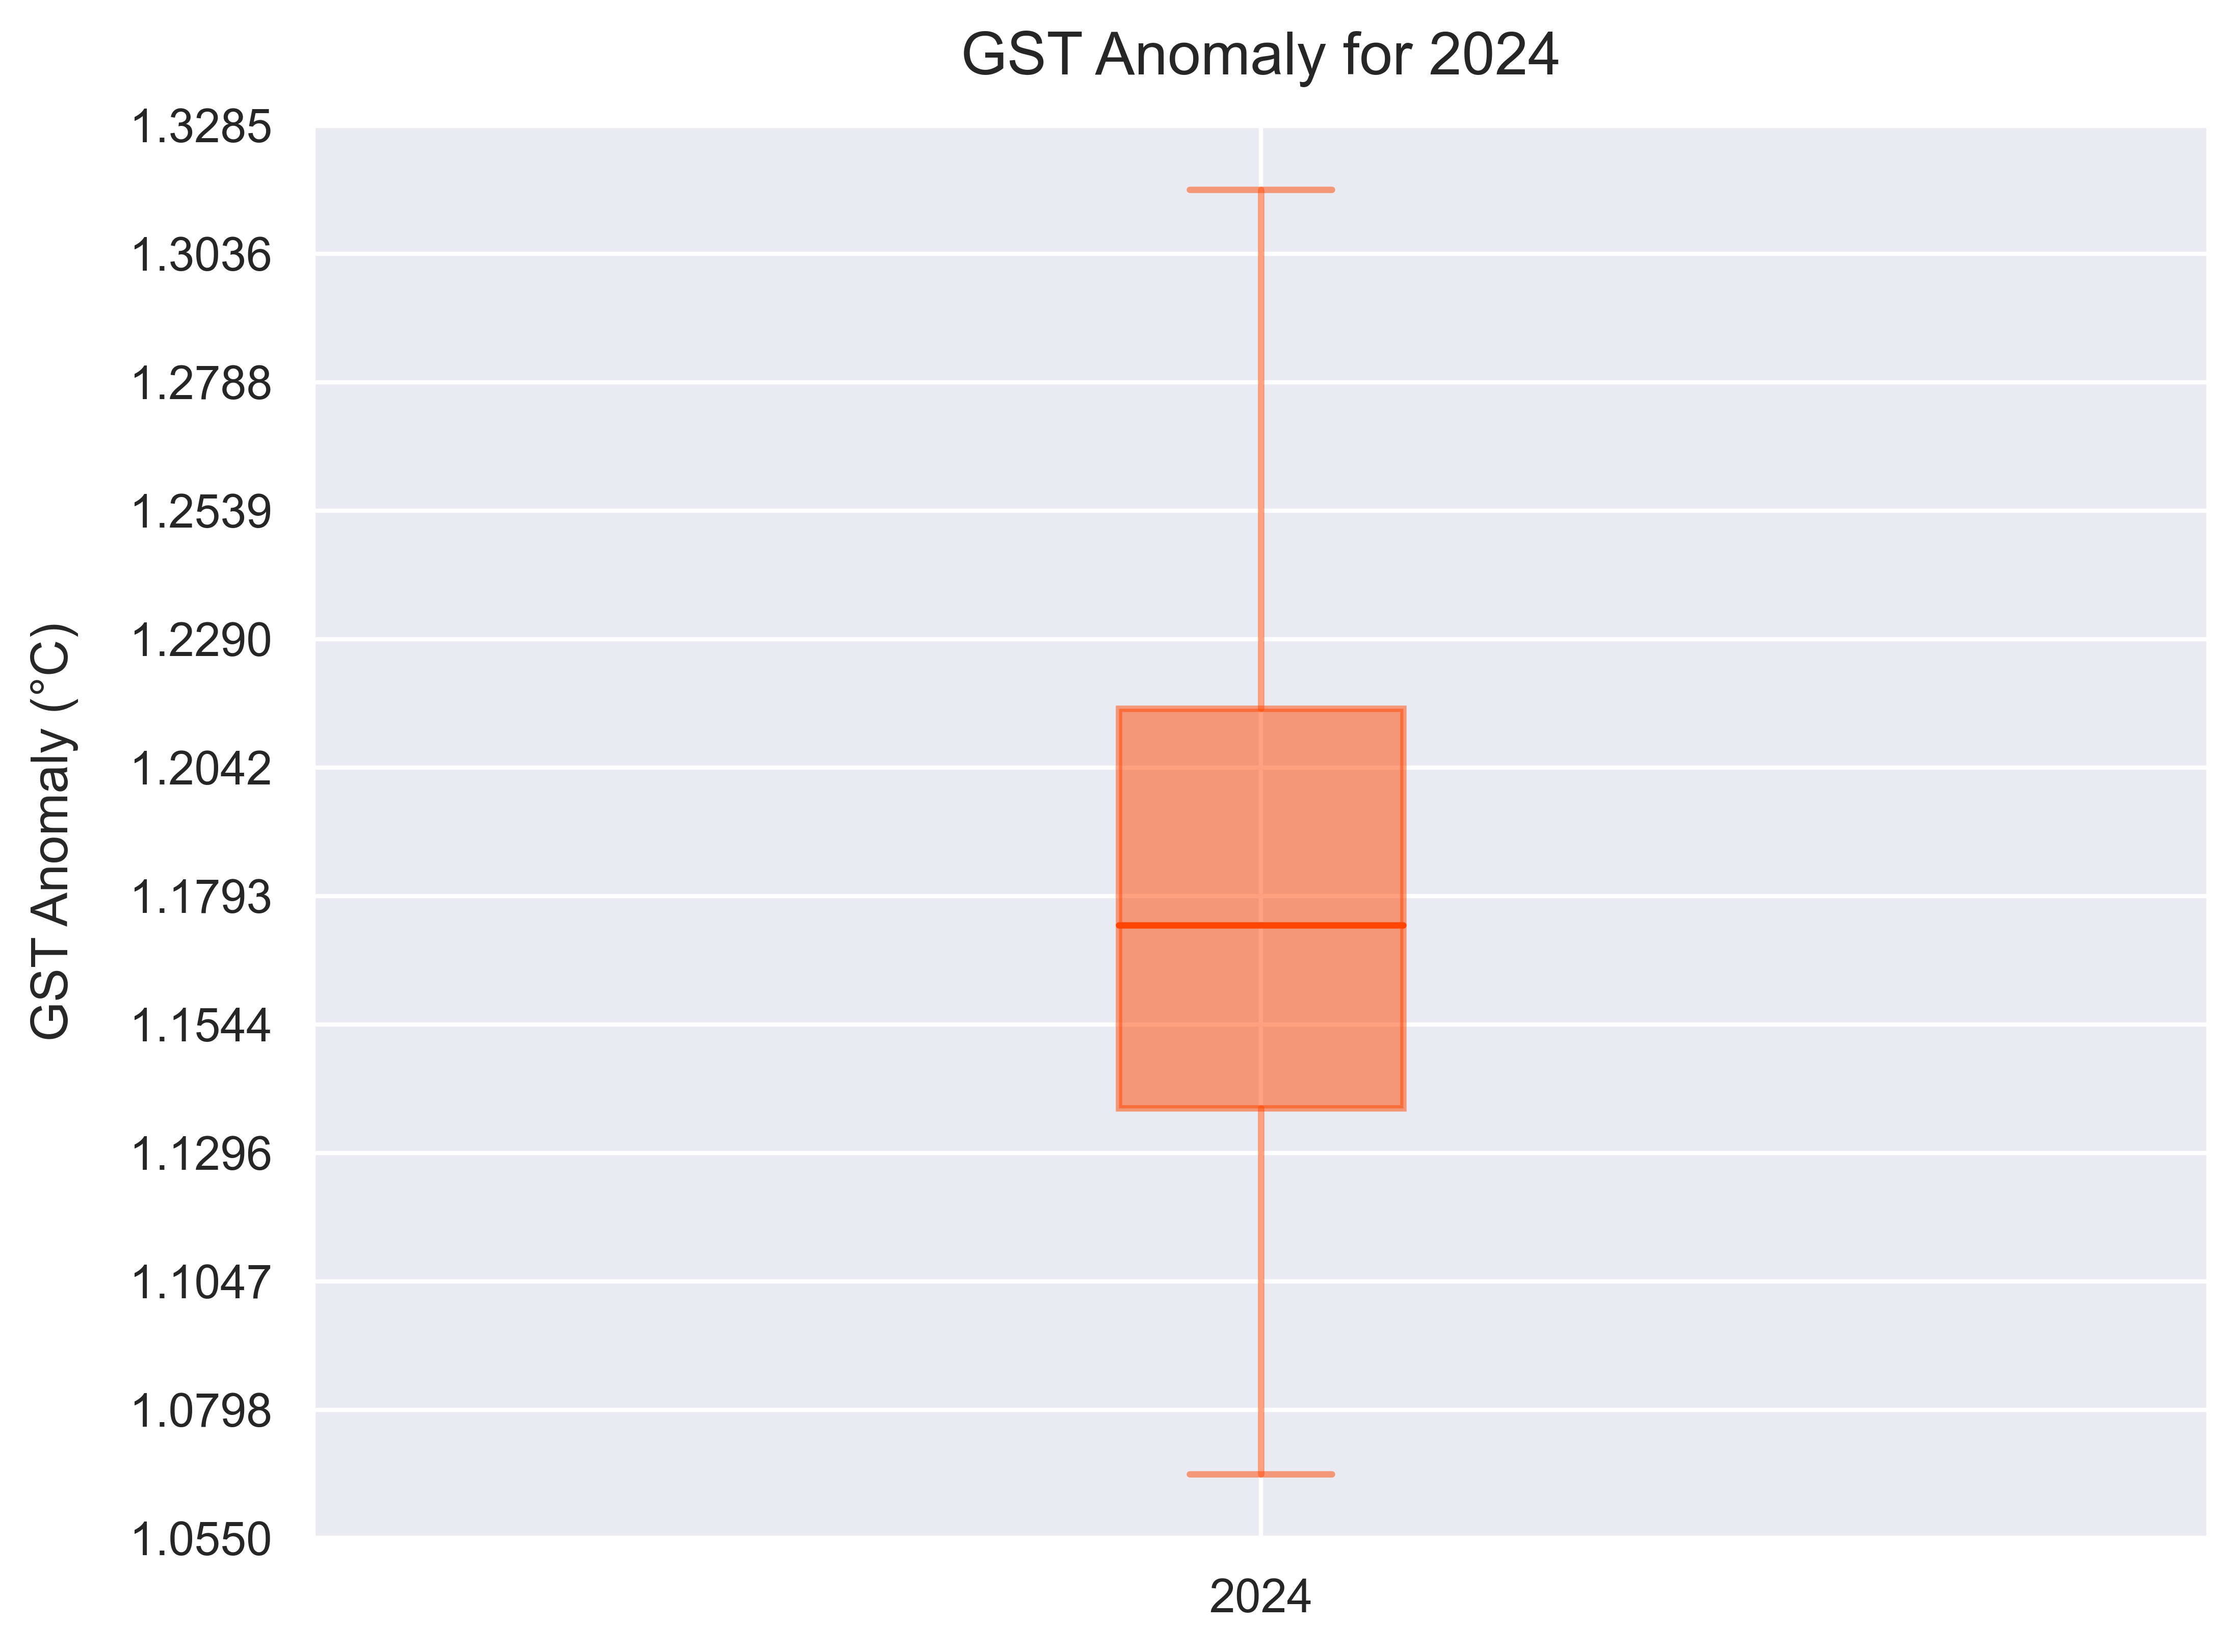

In [447]:
plot_boxplot("Temperature 2024", configs={
    "yLabel": "GST Anomaly (°C)",
    "title": "GST Anomaly for 2024",
    "facecolor": "#FF4500",
    "col1_label": "2024",
    "int_x": False
})